# Scikit-Learn
## Don't forget to normalize your data!

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import json
import re
import string
import collections
import math
import glob
import itertools

from pprint import pprint
import random
import sklearn

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.neighbors import DistanceMetric

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.io import push_notebook

In [2]:
# %save auto_cluster_sklearn-save2 1-328

In [2]:
%matplotlib notebook

In [135]:
pd.describe_option('display')

display.chop_threshold : float or None
    if set to a float value, all float values smaller then the given threshold
    will be displayed as exactly 0 by repr and friends.
    [default: None] [currently: None]

display.colheader_justify : 'left'/'right'
    Controls the justification of column headers. used by DataFrameFormatter.
    [default: right] [currently: right]

display.column_space No description available.
    [default: 12] [currently: 12]

display.date_dayfirst : boolean
    When True, prints and parses dates with the day first, eg 20/01/2005
    [default: False] [currently: False]

display.date_yearfirst : boolean
    When True, prints and parses dates with the year first, eg 2005/01/20
    [default: False] [currently: False]

display.encoding : str/unicode
    Defaults to the detected encoding of the console.
    Specifies the encoding to be used for strings returned by to_string,
    these are generally strings meant to be displayed on the console.
    [default: UTF-8] 

In [137]:
pd.set_option('display.width', 140)
pd.set_option('display.max_colwidth', 80)
# pd.describe_option('display')

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
plt.style.use('seaborn-colorblind')

In [5]:
np.set_printoptions(linewidth=150, precision=4, suppress=True)

In [6]:
def fullname(name):
    return os.path.join('/srv/bs/mirror/nasa', name)

def convertedname(name):
    return os.path.join('/srv/bs/mirror/nasa/converted', name + '.txt')

def chunkstring(string, length):
    "A generator which return the string, split up into fixed-width substrings of given length"
    return (string[0+i:length+i] for i in range(0, len(string), length))

def dswrite(data, recordLen, colspecs, path=None):
    """Write out the records in a text format that can be read by pandas.read_fwf()
    Use the given path name if given, or '/tmp/file.txt' if not.
    Create all directores needed.
    FIXME: somehow check whether the last record is valid
    """
    path = path or "/tmp/file.txt"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        for l in chunkstring(data, recordLen):
            print(l, file=f)

def dsconvert(fn, encoding, recordLen, colspecs):
    with open(fullname(fn), 'r', encoding=encoding) as f:
        data = f.read()
        dswrite(data, recordLen, colspecs, convertedname(fn))

FIXME: Make these chardet-related functions into a little class

In [7]:
# Note last 5 are formatting codes: newline, cr, tab, vertical tab, form feed
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [8]:
string.printable[:95]

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

In [9]:
printable_ascii_byte_codes = frozenset(ord(c) for c in string.printable[:95])

In [10]:
# Pulled out of Python encodings/cp037.py
printable_ebcdic_for_ascii_byte_codes = frozenset([0x40, 0x4B, 0x4C, 0x4D, 0x4E, 0x4F, 0x50, 0x5A, 0x5B, 0x5C, 0x5D, 0x5E, 0x60, 0x61,
 0x6B, 0x6C, 0x6D, 0x6E, 0x6F, 0x79, 0x7A, 0x7B, 0x7C, 0x7D, 0x7E, 0x7F, 0x81, 0x82,
 0x83, 0x84, 0x85, 0x86, 0x87, 0x88, 0x89, 0x91, 0x92, 0x93, 0x94, 0x95, 0x96, 0x97,
 0x98, 0x99, 0xA1, 0xA2, 0xA3, 0xA4, 0xA5, 0xA6, 0xA7, 0xA8, 0xA9, 0xB0, 0xBA, 0xBB,
 0xC0, 0xC1, 0xC2, 0xC3, 0xC4, 0xC5, 0xC6, 0xC7, 0xC8, 0xC9, 0xD0, 0xD1, 0xD2, 0xD3,
 0xD4, 0xD5, 0xD6, 0xD7, 0xD8, 0xD9, 0xE0, 0xE2, 0xE3, 0xE4, 0xE5, 0xE6, 0xE7, 0xE8,
 0xE9, 0xF0, 0xF1, 0xF2, 0xF3, 0xF4, 0xF5, 0xF6, 0xF7, 0xF8, 0xF9])

In [11]:
len(printable_ebcdic_for_ascii_byte_codes)

95

In [12]:
len(printable_ascii_byte_codes.union(printable_ebcdic_for_ascii_byte_codes))

165

In [13]:
def unprintable_codes(docindex):
    doc = j[docindex]
    doccodes = frozenset(code for code, freq in doc['bytefreqs'])
    return (
        doccodes.difference(printable_ebcdic_for_ascii_byte_codes),
        doccodes.difference(printable_ascii_byte_codes))

In [148]:
unprintable_codes(-2)

({0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  95,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  128,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  170,
  171,
  172,
  173,
  174,
  175,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  188,
  189,
  190,
  191,
  202,
  203,
  204,
  205,
  206,
  207,
  218,
  219,
  220,
  221,
  222,
  223,
  225,
  234,
  235,
  236,
  237,
  238,
  239,
  250,
  25

In [14]:
def chardet_all():
    charsets = []
    lens = []
    pxs = []
    pas = []
    pes = []
    for i in range(len(j)):
        (pe, pa) = unprintable_codes(i)
        lpe = len(pe)
        lpa = len(pa)
        lpx = min(lpe, lpa)
        if lpe < lpa:
            charset = 'cp037'
            lpx = lpe
            px = pe
        else:
            charset = 'ascii'
            lpx = lpa
            px = pa
        charsets.append(charset)
        lens.append(lpx)
        pxs.append(px)
        pas.append(pa)
        pes.append(pe)
    return (charsets, lens, pxs, pes, pas)

In [80]:
def showpoints(data, indices):
    "print and plot info on given indices in the data"
    euclid = DistanceMetric.get_metric('euclidean')
    with open('/tmp/q', 'w') as f:
      for i in indices:
        prediction = kmeans.predict(data[[i]])[0]
        dist = euclid.pairwise([kmeans.cluster_centers_[prediction], data[i]])[0,1]
        print(prediction, "%9s" % charsets[i], j[i]['topbytes'], data[i], dist, labels[i], file=f)
    d = data[indices]
    plt.scatter(d[:, 0], d[:, 1],
            marker='x', s=50, linewidths=1,
            color='b', zorder=10)

In [27]:
def entropy_from_byte_counts(byte_counts):
    """Calculate entropy in bits given list of counts of each byte value"""

    entropy = 0

    total = sum(byte_counts)
    for count in byte_counts:
        # If no bytes of this value were seen in the value, it doesn't affect
        # the entropy of the file.
        if count == 0:
            continue
        # p is the probability of seeing this byte in the file, as a floating-
        # point number
        p = 1.0 * count / total
        entropy -= p * math.log(p, 2)
    return entropy

In [52]:
entropy_from_byte_counts([3]*128)

7.0

In [208]:
# alternative, at the cost of a big(?) import
import scipy.stats
scipy.stats.entropy([3]*128, base=2)

7.0

## Read in and calculate assignment data

FIXME: Make these assignment-related functions into a little class...

In [15]:
project_assignments = pd.read_csv('data/NASA_Project_Assignments.csv', keep_default_na=False)

In [16]:
project_assignments

NSSDC ID  Priority (6 is high)  \
0       SPIO-00061                     6   
1       SPIO-00263                     6   
2       SPIO-00048                     6   
3       SPMS-00544                     6   
4       SPMS-00050                     6   
5       SPMS-00497                     6   
6       SPMS-00026                     6   
7       SPMS-00211                     6   
8       SPMS-00357                     6   
9       SPMS-00279                     6   
10      SPMS-00329                     6   
11      SPMS-00330                     6   
12      SPMS-00054                     6   
13      SPMS-00326                     6   
14   SPMS-00503 ??                     6   
15   SPIO-00265 ??                     6   
16   SPHE-00129 ??                     6   
17      SPHE-00743                     6   
18      SPHE-00383                     6   
19      SPHE-00537                     6   
20      SPHE-00250                     6   
21      SPHE-00727                     6   
22      SPHE-00616                     6   
23      SPHE-00120                     6   
24      SPHE-00171                     6   
25      SPHE-00704                     6   
26      SPHE-00633                     6   
27      SPHE-00634                     6   
28      SPHE-00393                     6   
29      SPHE-00394                     6   
..             ...                   ...   
110     SPHE-00615                     5   
111     SPHE-00731                     5   
112     SPMS-00425                     5   
113     SPMS-00147                     5   
114     SPMS-00117                     5   
115     SPMS-00484                     5   
116     SPHE-00465                     5   
117     SPMS-00113                     5   
118     SPMS-00395                     5   
119     SPMS-00190                     5   
120     SPHE-00349                     5   
121     SPHE-00669                     5   
122     SPHE-00202                     5   
123     SPMS-00493                     5   
124     SPIO-00160                     5   
125     SPIO-00282                     5   
126     SPIO-00219                     5   
127     SPMS-00110                     5   
128     SPHE-00692                     5   
129     SPMS-00341                     5   
130     SPHE-00070                     5   
131     SPHE-00460                     5   
132     SPHE-00494                     5   
133     SPHE-00066                     5   
134     SPHE-00492                     5   
135     SPHE-00366                     5   
136     SPHE-00482                     5   
137     SPHE-00498                     5   
138     SPHE-00280                     5   
139     SPHE-00412                     5   

              Data directory location of scanned files  \
0    http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...   
1    http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...   
2    http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...   
3    http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/bi...   
4    http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/el...   
5    http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/om...   
6    http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/om...   
7    http://spdf.gsfc.nasa.gov/pub/data/ats/ats5/tr...   
8    http://spdf.gsfc.nasa.gov/pub/data/azur/proton...   
9    http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
10   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
11   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
12   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
13   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
14   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
15   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
16   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
17   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
18   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
19   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
20   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
21   

In [17]:
assignment_urls = [str.strip(url) for url in list(project_assignments[project_assignments['Priority (6 is high)'] == 6]['Data directory location of scanned files'].values)]

In [18]:
assignment_urls

['http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thunderstorm-noise',
 'http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel3/vlf-receiver_fixed-frequency/signal_strength',
 'http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel4/langmuir_probe/multi-experiment',
 'http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/biaxial_fluxgate_magnetometer/15-sec_avg_vect_mag',
 'http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates',
 'http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/omnidirectional_spectrometer/proton-electron_flux',
 'http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/omnidirectional_spectrometer/proton-electron_flux_reformatted',
 'http://spdf.gsfc.nasa.gov/pub/data/ats/ats5/tri-directional_medium-energy_particle_detector/electron_proton_flux',
 'http://spdf.gsfc.nasa.gov/pub/data/azur/proton_telescope/particle_count_rates',
 'http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer12/proton-electron_scintillation_detector/re

In [551]:
for i, a in enumerate(as2):
    if assignment_urls[i] != a:
        print(a)
        print(assignment_urls[i])

In [19]:
collections.Counter([v[:4] for v in project_assignments['NSSDC ID'].values])

Counter({'SOUV': 2, 'SOXR': 2, 'SPHE': 78, 'SPIO': 21, 'SPMS': 37})

In [51]:
ignorepath = re.compile('^http://spdf.gsfc.nasa.gov/pub/data/')

In [38]:
def get_assignment(path):
    "Look given path up in list of assignments, and return index, or -1"
    for i, assignment_path in enumerate(project_assignments['Data directory location of scanned files']):
        assignment_path = assignment_path.strip()
        if path.startswith(assignment_path[35:] + '/'):
            return i
    return -1

In [28]:
def is_datafile(pathname):
    return not any([ext in pathname for ext in ['.pdf', '.html', '.tar', '.xml', '.txt', '.TAR', 'SHA1SUM']])

In [188]:
FileInfo = collections.namedtuple('FileInfo', 'path assignment length')

def allfiles():
    for assignment_ls_fn in glob.glob('data/ls/*'):
        for result in read_lftp_ls(assignment_ls_fn):
            yield result

def read_lftp_ls(fn):
    "Return tuples of (filename, assignment) for all data files in given "
    with open(fn, 'r') as f:
        for line in f.readlines():
            # e.g.:  drwxrwxr-x  leckner/spdf        6 2014-09-15 06:00:00 vela/vela-3a
            (perms, owners, length, date, time, *filename_maybe_symlinks) = line.split()
            # Ignore directories and symlinks like lrwxrwxrwx  leckner/kovalick   76 2014-09-09 06:00:00 symlink -> realfile
            if perms[0] != 'd' and len(filename_maybe_symlinks) == 1:
                filename = filename_maybe_symlinks[0]
                if is_datafile(filename):
                    assignment = get_assignment(filename)
                    yield FileInfo(filename, int(assignment), int(length))

In [39]:
get_assignment('ariel/ariel3/vlf-receiver_fixed-frequency/signal_strength/DATA2_DR002106_DR002106_20080804_071839/dr002106_f00001.phys.1')

1

## older approach to data for get_assignment()

In [21]:
with open('assignment_urls.txt', 'r') as f:
    assignment_urls = [l.strip() for l in f.readlines()]

In [22]:
assignment_urls[:3]

['http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thunderstorm-noise',
 'http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel3/vlf-receiver_fixed-frequency/signal_strength',
 'http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel4/langmuir_probe/multi-experiment']

In [23]:
assignment_paths = [ignorepath.sub('', p) for p in assignment_urls]

In [24]:
assignment_paths[:3]

['ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thunderstorm-noise',
 'ariel/ariel3/vlf-receiver_fixed-frequency/signal_strength',
 'ariel/ariel4/langmuir_probe/multi-experiment']

# ETL bytefreqs

In [54]:
with open("/srv/bs/mirror/nasa/assignments.json", 'r') as f: j = json.loads(f.read())

In [55]:
j[0]

{'blocks': 12853.0,
 'blocksize': 404,
 'bytefreqs': [[64, 4872],
  [1, 25],
  [75, 895],
  [242, 471],
  [240, 760],
  [241, 663],
  [146, 25],
  [243, 547],
  [244, 370],
  [245, 355],
  [246, 451],
  [247, 205],
  [248, 202],
  [249, 159]],
 'charset': 'cp037',
 'left_over': 0,
 'len': 5192612,
 'name': 'spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/DATA2_DR002945_DR002945_20080611_083040/dr002945_f00001.phys.1',
 'topbytes': ['40', '4b', 'f0', 'f1', 'f3', 'f2', 'f6', 'f4', 'f5', 'f7'],
 'upperbitchars': []}

In [56]:
del j[-1]

In [57]:
j[0]['name']

'spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/DATA2_DR002945_DR002945_20080611_083040/dr002945_f00001.phys.1'

In [58]:
orig_j = j

In [59]:
j = [r for r in orig_j  if is_datafile(r['name'][32:])  and  get_assignment(r['name'][32:]) != -1]

In [61]:
len(j), len(orig_j)

(4055, 5136)

In [62]:
labels = [r.get('name', [])[32:]  for r in j]

In [63]:
blocksizes = [r.get('blocksize', [])  for r in j]

In [64]:
entropy = [entropy_from_byte_counts([t[1] for t in bytefreqs])  for bytefreqs in [r['bytefreqs'] for r in j] ]

In [65]:
charsets0 = [r.get('charset', [])  for r in j]

In [66]:
lengths = [r.get('len', [])  for r in j]

In [67]:
topbytes = [r.get('topbytes', [])  for r in j]

In [68]:
assignments = [get_assignment(label) for label in labels]

In [69]:
assignments[:10]

[4, 15, 49, 49, 49, 49, 49, 49, 49, 49]

In [70]:
collections.Counter(assignments)

Counter({2: 1,
         3: 7,
         4: 1,
         5: 14,
         6: 6,
         7: 21,
         8: 3,
         11: 9,
         12: 1,
         13: 2,
         14: 10,
         15: 2,
         17: 2,
         20: 1,
         21: 1,
         22: 3,
         23: 32,
         24: 13,
         25: 1,
         26: 32,
         27: 2,
         28: 8,
         29: 8,
         30: 5,
         31: 8,
         32: 6,
         33: 223,
         34: 49,
         35: 12,
         36: 374,
         37: 163,
         38: 2,
         39: 3,
         43: 200,
         44: 4,
         45: 12,
         47: 32,
         49: 105,
         50: 4,
         51: 1,
         52: 161,
         53: 2,
         54: 400,
         55: 4,
         56: 4,
         57: 3,
         58: 7,
         59: 5,
         60: 5,
         61: 1,
         62: 23,
         63: 17,
         64: 14,
         65: 4,
         66: 305,
         68: 54,
         69: 31,
         70: 465,
         71: 240,
         72: 1,
         73:

In [71]:
bf = [r.get('bytefreqs', [])  for r in j]

In [72]:
bf[0]

[[64, 4872],
 [1, 25],
 [75, 895],
 [242, 471],
 [240, 760],
 [241, 663],
 [146, 25],
 [243, 547],
 [244, 370],
 [245, 355],
 [246, 451],
 [247, 205],
 [248, 202],
 [249, 159]]

In [73]:
bfa_unscaled = np.zeros((len(bf), 256), dtype=np.float64)

In [74]:
for i, row in enumerate(bf):
    for t in row:
        bfa_unscaled[i,t[0]] = t[1]

In [75]:
bfa_unscaled[:3,:]

array([[    0.,    25.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,  4872.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,   895.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 

In [76]:
labels[:5]

['ats/ats1/electron_spectrometer/6-min_avg_count_rates/DATA2_DR002945_DR002945_20080611_083040/dr002945_f00001.phys.1',
 'explorer/explorer31/plasma_cep/dmea_ne_te.asc',
 'imp/imp7/solar_flare_high-z/time-ordered_sectored_count-rates_pulse-heights/DATA2_DR001475_DR001475_20080611_083016/dr001475_f00001.phys.1',
 'imp/imp7/solar_flare_high-z/time-ordered_sectored_count-rates_pulse-heights/DATA2_DR001475_DR001475_20080611_083016/dr001475_f00002.phys.1',
 'imp/imp7/solar_flare_high-z/time-ordered_sectored_count-rates_pulse-heights/DATA2_DR001475_DR001475_20080611_083016/dr001475_f00003.phys.1']

In [81]:
(charsets, lens, pxs, pes, pas) = chardet_all()

In [82]:
lens[-10:]

[161, 161, 161, 161, 161, 161, 161, 161, 161, 1]

<IPython.core.display.Javascript object>


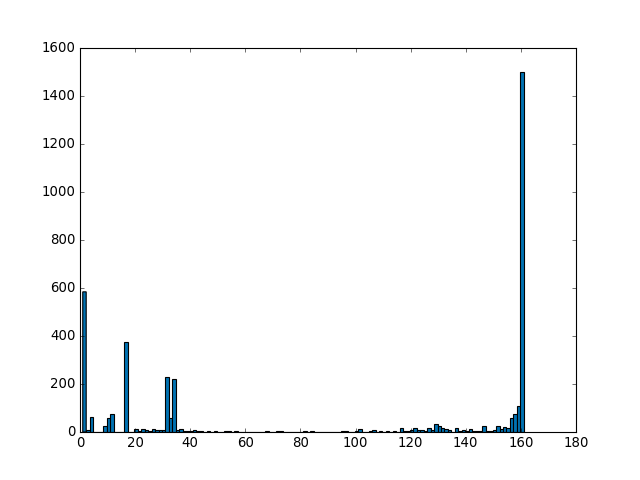

(array([  584.,     8.,    63.,     1.,     2.,     2.,    24.,    58.,    76.,     1.,     0.,     0.,   373.,     1.,     2.,    13.,     5.,    12.,
           10.,     4.,    11.,     7.,     7.,     8.,   229.,    59.,   222.,     7.,    11.,     3.,     3.,     3.,     7.,     3.,     3.,     0.,
            3.,     0.,     4.,     2.,     1.,     3.,     4.,     1.,     4.,     2.,     2.,     0.,     1.,     1.,     2.,     0.,     2.,     3.,
            0.,     1.,     4.,     4.,     0.,     1.,     1.,     2.,     1.,     1.,     4.,     1.,     4.,     0.,     2.,     0.,     1.,     0.,
            2.,     1.,     1.,     3.,     4.,     2.,     1.,     3.,    11.,     1.,     1.,     5.,     8.,     0.,     6.,     0.,     5.,     2.,
            3.,     1.,    17.,     6.,     6.,     7.,    15.,     9.,     7.,     6.,    15.,     7.,    34.,    27.,    15.,    11.,     8.,     2.,
           15.,     5.,     7.,     5.,    13.,     5.,     5.,     5.,    23.,     6., 

In [84]:
plt.hist(lens, bins=128)

In [85]:
collections.Counter(lens)

Counter({1: 497,
         2: 87,
         3: 8,
         4: 63,
         5: 1,
         6: 1,
         7: 1,
         8: 2,
         9: 24,
         10: 58,
         11: 76,
         13: 1,
         17: 373,
         18: 1,
         19: 2,
         20: 13,
         21: 1,
         22: 4,
         23: 12,
         24: 10,
         25: 4,
         26: 7,
         27: 4,
         28: 7,
         29: 7,
         30: 8,
         31: 5,
         32: 224,
         33: 59,
         34: 222,
         35: 7,
         36: 4,
         37: 7,
         38: 3,
         39: 3,
         40: 3,
         41: 5,
         42: 2,
         43: 3,
         44: 3,
         46: 3,
         49: 4,
         50: 2,
         51: 1,
         53: 3,
         54: 4,
         55: 1,
         56: 2,
         57: 2,
         58: 2,
         59: 2,
         61: 1,
         63: 1,
         64: 2,
         67: 2,
         68: 3,
         70: 1,
         71: 1,
         72: 3,
         73: 4,
         75: 1,
         76: 1,


In [88]:
unprintables_as_ebcdic = [len(unprintable_codes(docindex)[0]) for docindex in range(len(j))]

In [90]:
len(unprintables_as_ebcdic)

4055

In [123]:
len(unprintables_as_ebcdic)

5136

In [92]:
def show_n(name):
    with open(fullname(name), 'rb') as f:
        return f.read(1000)

In [62]:
j[1]

{'blocks': 55870.0,
 'blocksize': 114,
 'bytefreqs': [[65, 14],
  [66, 9],
  [67, 11],
  [69, 82],
  [70, 45],
  [71, 22],
  [10, 87],
  [75, 14],
  [76, 20],
  [77, 14],
  [78, 12],
  [79, 42],
  [83, 17],
  [84, 17],
  [32, 3481],
  [101, 5],
  [43, 87],
  [45, 100],
  [46, 351],
  [48, 449],
  [49, 1046],
  [50, 678],
  [51, 725],
  [52, 374],
  [53, 440],
  [54, 290],
  [55, 297],
  [56, 215],
  [57, 1047],
  [74, 9]],
 'charset': 'iso8859-1',
 'left_over': 0,
 'len': 6369180,
 'name': 'spdf.sci.gsfc.nasa.gov/pub/data/explorer/explorer31/plasma_cep/dmea_ne_te.asc',
 'topbytes': ['20', '39', '31', '33', '32', '30', '35', '34', '2e', '37'],
 'upperbitchars': []}

In [93]:
def showindex(jindex):
    ji = j[jindex]
    with open(fullname(ji['name']), 'r', encoding=ji['charset']) as f:
        data = f.read()
        for i, l in enumerate(chunkstring(data, ji['blocksize'])):
            print(l)
            if i > 10:
                break


In [74]:
assignments[3038]

62

In [75]:
assignment_paths[62]

'isee/isee1/quasi-static_low-freq_electric_fields'

In [73]:
j[3038]

{'blocks': 33113.791666666664,
 'blocksize': 96,
 'bytefreqs': [[0, 5306],
  [1, 204],
  [2, 11],
  [3, 20],
  [4, 43],
  [5, 42],
  [6, 36],
  [7, 40],
  [8, 22],
  [9, 14],
  [10, 4],
  [11, 7],
  [12, 5],
  [14, 2],
  [15, 1],
  [16, 4],
  [17, 7],
  [18, 4],
  [19, 2],
  [20, 1],
  [21, 2],
  [22, 3],
  [23, 3],
  [24, 4],
  [25, 3],
  [26, 19],
  [27, 18],
  [28, 26],
  [29, 13],
  [30, 10],
  [31, 16],
  [32, 13],
  [33, 12],
  [34, 16],
  [35, 16],
  [36, 26],
  [37, 9],
  [38, 8],
  [39, 7],
  [40, 6],
  [41, 8],
  [42, 6],
  [43, 10],
  [44, 20],
  [45, 3],
  [46, 7],
  [47, 2],
  [48, 2],
  [50, 9],
  [51, 13],
  [52, 24],
  [53, 21],
  [54, 23],
  [55, 23],
  [56, 15],
  [57, 2],
  [58, 4],
  [59, 9],
  [60, 149],
  [61, 21],
  [62, 133],
  [63, 533],
  [64, 575],
  [65, 31],
  [66, 31],
  [67, 6],
  [68, 123],
  [69, 135],
  [70, 47],
  [71, 5],
  [72, 20],
  [73, 30],
  [74, 54],
  [75, 3],
  [77, 3],
  [78, 2],
  [79, 18],
  [80, 2],
  [81, 1],
  [82, 3],
  [84, 1],
  [85

In [76]:
df.ix[3083]

assignment                                                   66
blocksize                                                   170
charset                                                   cp037
cluster                                                       3
dataset       ogo/ogo3/triaxial_search-coil_magnetometer/36p...
entropy                                                0.371544
lengths                                                  171870
x                                                      -4.01601
y                                                      -6.58895
Name: 3083, dtype: object

In [69]:
showindex(3083)

 y0OGO-3 ORBIT   2 EXPT 10 COMPRESSED DATA ARCHIVE, SEARCH COIL MAGNETOMETER, STARTING AT 15300 SEC OF DAY 160, 1966                                                      
 y DATA WORDS ARE 3 CHARACTERS EACH, EXCEPT TIMES WHICH ARE 6, 168 CHARACTERS PER RECORD, IN THE FOLLOWING ORDER -                                                        
 y DAY,X10,X30,X100,X300,X1000,Y10,Y30,Y100,Y300,Y1000,Z30,Z100,Z300,Z1000,SCALE,TIME%1<,Z10%1<,HFX%1<,HFY%1<,HFZ%1<,                                                     
 y LFX%1<,LFY%1<,LFZ%1<,BP%1<, ETC FOR TIME%2<, TIME%3<, TIME%4<. DAY#700 INDICATES DECOM END OF FILE, MAYBE TIME GAP.                                                    
 y                                                                                                                                                                        
 y                                                                                                                                               

# Bytefreq clusering

In [77]:
#bfa = scale(bfa_unscaled)
scaler = StandardScaler().fit(bfa_unscaled)
bfa = scaler.transform(bfa_unscaled)

In [78]:
bfa[:3]

array([[ -0.913 ,  -0.7638,  -0.9227,  -0.7743,  -0.7751,  -0.6758,  -0.6048,  -0.7333,  -0.7115,  -0.4794,  -0.3843,  -0.5088,  -0.4502,  -0.6074,
         -0.5546,  -0.5216,  -0.3991,  -0.5915,  -0.4985,  -0.5333,  -0.4458,  -0.5382,  -0.4103,  -0.5305,  -0.342 ,  -0.4873,  -0.4788,  -0.5277,
         -0.4583,  -0.5138,  -0.2862,  -0.4306,  -0.2754,  -0.388 ,  -0.387 ,  -0.416 ,  -0.28  ,  -0.4478,  -0.3905,  -0.4079,  -0.3614,  -0.4105,
         -0.3721,  -0.4063,  -0.3485,  -0.4247,  -0.3282,  -0.4367,  -0.3231,  -0.3397,  -0.3349,  -0.349 ,  -0.3698,  -0.4924,  -0.3696,  -0.3026,
         -0.3029,  -0.3156,  -0.3781,  -0.395 ,  -0.3021,  -0.3798,  -0.5141,  -0.5066,   3.2278,  -0.4901,  -0.2366,  -0.3789,  -0.4847,  -0.3089,
         -0.4609,  -0.3974,  -0.5584,  -0.4589,  -0.3117,  13.9896,  -0.4012,  -0.4517,  -0.2051,  -0.2157,  -0.395 ,  -0.4419,  -0.3592,  -0.4502,
         -0.4625,  -0.4816,  -0.3645,  -0.5354,  -0.3372,  -0.5489,  -0.3494,  -0.372 ,  -0.4491,  -0.4782,  -0.

In [79]:
k = 10
pca = PCA(n_components=2).fit(bfa)
reduced_data = pca.transform(bfa)
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit(reduced_data)

predictions = kmeans.predict(reduced_data)
prediction_counts = collections.Counter(predictions)

In [98]:
df = pd.DataFrame(dict(
    dataset=[r['name'][32:120]  for r in j],
    assignment=assignments,
    charset=charsets,
    numnonprint = lens,
    nonprinting = pxs,
    cluster=predictions,
    entropy=entropy,
    charset0=charsets0,
    lengths=lengths,
    blocksize=blocksizes,
    x=reduced_data[:,0],
    y=reduced_data[:,1]
))

In [280]:
df

assignment  blocksize charset   charset0  cluster  \
0              4        404   cp037      cp037        2   
1             15        114   ascii  iso8859-1        4   
2             49          6   ascii  iso8859-1        9   
3             49          6   ascii  iso8859-1        9   
4             49          6   ascii  iso8859-1        9   
5             49          6   ascii  iso8859-1        9   
6             49          6   cp037  iso8859-1        9   
7             49          6   cp037  iso8859-1        9   
8             49        360   ascii  iso8859-1        9   
9             49          6   ascii  iso8859-1        9   
10            49        360   ascii  iso8859-1        9   
11            49          6   ascii  iso8859-1        9   
12            49          6   ascii  iso8859-1        9   
13            49          6   cp037  iso8859-1        7   
14            49          6   ascii  iso8859-1        7   
15            49        360   cp037  iso8859-1        9   
16            49          6   cp037  iso8859-1        9   
17            49          6   ascii      cp037        1   
18            49          6   ascii  iso8859-1        9   
19            49          1   cp037  iso8859-1        1   
20            49          6   ascii  iso8859-1        9   
21            49          6   cp037  iso8859-1        9   
22            49          6   cp037  iso8859-1        9   
23            49          6   ascii  iso8859-1        9   
24            49          6   ascii  iso8859-1        9   
25            49          6   cp037  iso8859-1        9   
26            49          3   cp037      cp037        1   
27            49          6   ascii  iso8859-1        9   
28            49          6   ascii  iso8859-1        7   
29            49          6   ascii  iso8859-1        9   
...          ...        ...     ...        ...      ...   
4025          91        122   cp037  iso8859-1        2   
4026          91        122   cp037  iso8859-1        2   
4027          91        122   cp037  iso8859-1        2   
4028          91        122   cp037  iso8859-1        2   
4029          91        122   cp037  iso8859-1        2   
4030          91        122   cp037  iso8859-1        2   
4031          91        122   cp037  iso8859-1        2   
4032          91        122   cp037  iso8859-1        2   
4033          91        122   cp037  iso8859-1        2   
4034          92        535   ascii      cp037        8   
4035          92        535   ascii      cp037        6   
4036          92        535   ascii      cp037        7   
4037          92        535   ascii      cp037        7   
4038          92        535   ascii      cp037        3   
4039          92        535   ascii      cp037        0   
4040          92        535   ascii  iso8859-1        3   
4041          92        535   ascii      cp037        3   
4042          92        535   ascii      cp037        3   
4043          92        535   ascii      cp037        3   
4044          92        535   ascii      cp037        8   
4045          92        535   ascii      cp037        8   
4046          92        535   ascii      cp037        3   
4047          92        535   ascii      cp037        3   
4048          92        535   ascii      cp037        3   
4049          92        535   ascii      cp037        3   
4050          92        535   ascii      cp037        3   
4051          92        535   ascii  iso8859-1        8   
4052          92        535   ascii  iso8859-1        3   
4053          92          1   ascii      cp037        6   
4054          93         86   ascii  iso8859-1        4   

                                                dataset   entropy  lengths  \
0     ats/ats1/electron_spectrometer/6-min_avg_count...  2.711605  5192612   
1         explorer/explorer31/plasma_cep/dmea_ne_te.asc  3.378567  6369180   
2     imp/imp7/solar_flare_high-z/time-ordered_secto...  4.321808  5579596   
3     imp/imp7/solar_flare_high-z/t

In [194]:
af = pd.DataFrame(allfiles())

In [195]:
af

path  assignment   length
0      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3270980
1      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3270980
2      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3271308
3      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3270652
4      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3270816
5      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3270980
6      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3258468
7      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3478466
8      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3249924
9      ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  2541484
10     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3235656
11     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3850074
12     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3727648
13     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  2088524
14     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3271308
15     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  2367430
16     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  2797480
17     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  2904118
18     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3225744
19     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3530744
20     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3688962
21     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  1566578
22     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3282648
23     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3228742
24     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3088606
25     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  2271250
26     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3390536
27     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3325186
28     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3404514
29     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3752878
30     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3564140
31     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3176334
32     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3843450
33     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3976826
34     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3464822
35     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...           0  3385660
36     ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thundersto...

In [197]:
af.sort_values(by=['length'], ascending=False).head()

path  assignment     length
28610  imp/imp4/triaxial_fluxgate_magnetometer/2_dot_5_sec_mag_fld_vectors/DR001645...          30  162294084
28592  imp/imp4/triaxial_fluxgate_magnetometer/2_dot_5_sec_mag_fld_vectors/DR001640...          30  161961246
28601  imp/imp4/triaxial_fluxgate_magnetometer/2_dot_5_sec_mag_fld_vectors/DR001644...          30  154129576
28673  imp/imp4/triaxial_fluxgate_magnetometer/2_dot_5_sec_mag_fld_vectors/DR001653...          30  152779720
28664  imp/imp4/triaxial_fluxgate_magnetometer/2_dot_5_sec_mag_fld_vectors/DR001652...          30  151435504

In [202]:
af['logLength'] = af.length.apply(lambda x: math.log(x, 10))

<IPython.core.display.Javascript object>


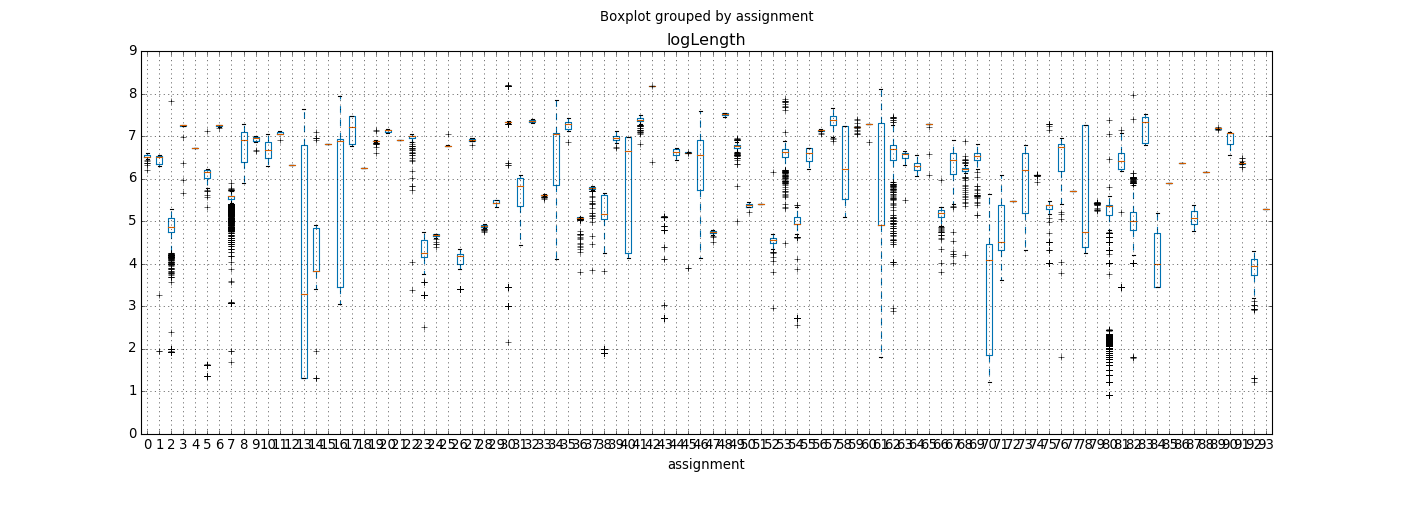

In [203]:

af.boxplot('logLength', by='assignment');

In [211]:
g = af.groupby('assignment')

In [216]:
x = g['length']

In [230]:
!python -c "import IPython; print(IPython.sys_info())"


{'commit_hash': '5c9c918',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/home/neal/Envs/hug/lib/python3.4/site-packages/IPython',
 'ipython_version': '5.1.0',
 'os_name': 'posix',
 'platform': 'Linux-4.4.0-75-generic-x86_64-with-Ubuntu-14.04-trusty',
 'sys_executable': '/home/neal/Envs/hug/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.4.3 (default, Nov 17 2016, 01:08:31) \n[GCC 4.8.4]'}


<IPython.core.display.Javascript object>


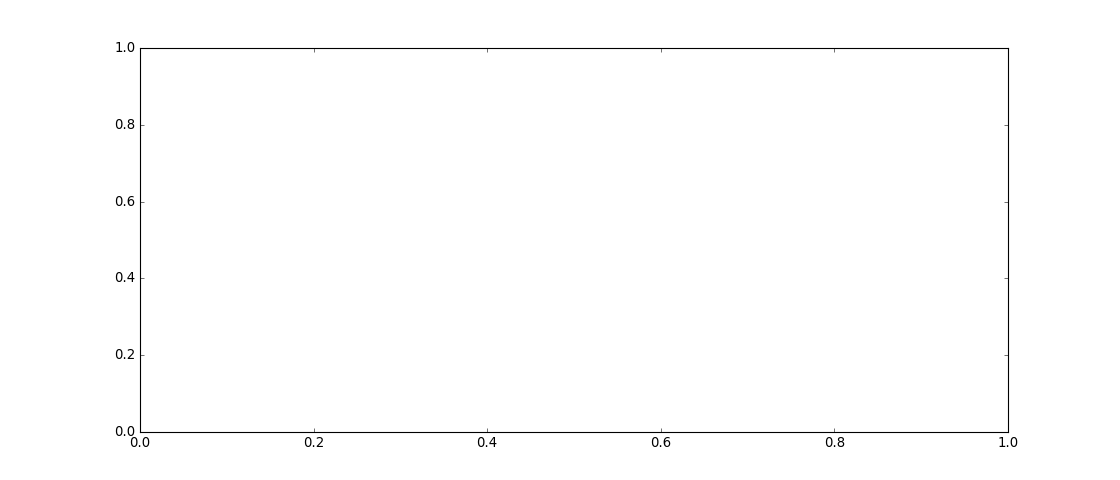

TypeError: boxplot() got an unexpected keyword argument 'by'

In [227]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.boxplot(af['length'], by='assignment', whis=[5, 95])
ax.set_yscale('log')

In [ ]:
af.boxplot('length', by='assignment');

<IPython.core.display.Javascript object>


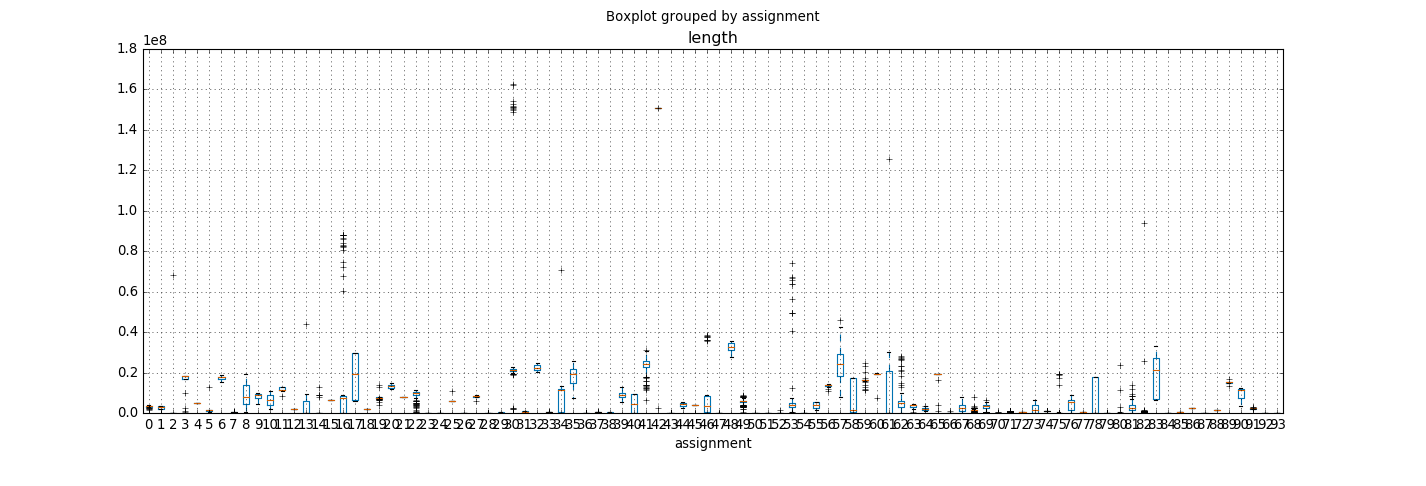

In [204]:
af.boxplot('length', by='assignment');

In [99]:
filecounts = pd.Series(collections.Counter([t[1] for t in allfiles()]), name='datafiles')

In [100]:
filecounts

0        48
1        20
2     18116
3        20
4         1
5       246
6        10
7      8247
8         3
9        16
10        2
11       16
12        6
13      137
14      124
15        1
16      560
17        6
18        1
19      113
20        7
21        1
22      207
23      361
24       48
25        6
26      130
27        5
28      120
29        5
      ...  
64       21
65       13
66      305
67      288
68      254
69      215
70     7884
71     6523
72        1
73       18
74      120
75      166
76      246
77        1
78       58
79     5104
80    22507
81       66
82     3879
83       46
84        8
85        1
86        1
87        2
88        1
89        6
90        3
91       21
92     3170
93        1
Name: datafiles, dtype: int64

In [107]:
cachecounts = df.groupby(['assignment']).size()

In [108]:
cachecounts

assignment
2       1
3       7
4       1
5      14
6       6
7      21
8       3
11      9
12      1
13      2
14     10
15      2
17      2
20      1
21      1
22      3
23     32
24     13
25      1
26     32
27      2
28      8
29      8
30      5
31      8
32      6
33    223
34     49
35     12
36    374
     ... 
63     17
64     14
65      4
66    305
68     54
69     31
70    465
71    240
72      1
73     17
74     70
75    160
76     24
77      1
78     13
79    207
80      2
81     19
82    344
83      7
84      8
85      1
86      1
87      2
88      1
89      4
90      3
91     21
92     20
93      1
dtype: int64

In [109]:
pa = project_assignments.join(filecounts).join(cachecounts.rename('cachecounts')).fillna(0)

In [124]:
pa

NSSDC ID  Priority (6 is high)  \
0       SPIO-00061                     6   
1       SPIO-00263                     6   
2       SPIO-00048                     6   
3       SPMS-00544                     6   
4       SPMS-00050                     6   
5       SPMS-00497                     6   
6       SPMS-00026                     6   
7       SPMS-00211                     6   
8       SPMS-00357                     6   
9       SPMS-00279                     6   
10      SPMS-00329                     6   
11      SPMS-00330                     6   
12      SPMS-00054                     6   
13      SPMS-00326                     6   
14   SPMS-00503 ??                     6   
15   SPIO-00265 ??                     6   
16   SPHE-00129 ??                     6   
17      SPHE-00743                     6   
18      SPHE-00383                     6   
19      SPHE-00537                     6   
20      SPHE-00250                     6   
21      SPHE-00727                     6   
22      SPHE-00616                     6   
23      SPHE-00120                     6   
24      SPHE-00171                     6   
25      SPHE-00704                     6   
26      SPHE-00633                     6   
27      SPHE-00634                     6   
28      SPHE-00393                     6   
29      SPHE-00394                     6   
..             ...                   ...   
110     SPHE-00615                     5   
111     SPHE-00731                     5   
112     SPMS-00425                     5   
113     SPMS-00147                     5   
114     SPMS-00117                     5   
115     SPMS-00484                     5   
116     SPHE-00465                     5   
117     SPMS-00113                     5   
118     SPMS-00395                     5   
119     SPMS-00190                     5   
120     SPHE-00349                     5   
121     SPHE-00669                     5   
122     SPHE-00202                     5   
123     SPMS-00493                     5   
124     SPIO-00160                     5   
125     SPIO-00282                     5   
126     SPIO-00219                     5   
127     SPMS-00110                     5   
128     SPHE-00692                     5   
129     SPMS-00341                     5   
130     SPHE-00070                     5   
131     SPHE-00460                     5   
132     SPHE-00494                     5   
133     SPHE-00066                     5   
134     SPHE-00492                     5   
135     SPHE-00366                     5   
136     SPHE-00482                     5   
137     SPHE-00498                     5   
138     SPHE-00280                     5   
139     SPHE-00412                     5   

              Data directory location of scanned files  \
0    http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...   
1    http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...   
2    http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel...   
3    http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/bi...   
4    http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/el...   
5    http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/om...   
6    http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/om...   
7    http://spdf.gsfc.nasa.gov/pub/data/ats/ats5/tr...   
8    http://spdf.gsfc.nasa.gov/pub/data/azur/proton...   
9    http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
10   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
11   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
12   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
13   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
14   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
15   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
16   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
17   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
18   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
19   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
20   http://spdf.gsfc.nasa.gov/pub/data/explorer/ex...   
21   

In [131]:
pd.set_option('display.max_rows', 200)

In [138]:
pa[[1,2,19,20]]

Priority (6 is high)                                         Data directory location of scanned files  datafiles  cachecounts
0                       6  http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel3/langmuir_probe/plasma-freque...       48.0          0.0
1                       6  http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel3/vlf-receiver_fixed-frequency...       20.0          0.0
2                       6  http://spdf.gsfc.nasa.gov/pub/data/ariel/ariel4/langmuir_probe/multi-experiment    18116.0          1.0
3                       6  http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/biaxial_fluxgate_magnetometer/15...       20.0          7.0
4                       6  http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_...        1.0          1.0
5                       6  http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/omnidirectional_spectrometer/pro...      246.0         14.0
6                       6  http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/omnidirectional_spectrometer/pro...       10.0          6.0
7                       6  http://spdf.gsfc.nasa.gov/pub/data/ats/ats5/tri-directional_medium-energy_pa...     8247.0         21.0
8                       6    http://spdf.gsfc.nasa.gov/pub/data/azur/proton_telescope/particle_count_rates        3.0          3.0
9                       6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer12/proton-electron_scint...       16.0          0.0
10                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer14/cosmic_rays/gm_scinti...        2.0          0.0
11                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer14/cosmic_rays/gm_scinti...       16.0          9.0
12                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer26/solid-state_electron_...        6.0          1.0
13                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer26/solid-state_electron_...      137.0          2.0
14                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer26/solid-state_electron_...      124.0         10.0
15                      6                http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer31/plasma_cep        1.0          2.0
16                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer33/ames_magnetic_fields/...      560.0          0.0
17                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer33/ames_magnetic_fields/...        6.0          2.0
18                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer33/fluxgate_magnetometer...        1.0          0.0
19                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer33/gsfc_magnetometer/5pt...      113.0          0.0
20                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer33/ion_chamber_gm_counte...        7.0          1.0
21                      6  http://spdf.gsfc.nasa.gov/pub/data/explorer/explorer35/plasma_probe/3-min_in...        1.0          1.0
22                      6  http://spdf.gsfc.nasa.gov/pub/data/imp/aimp-2_imp-e/ames_magnetic_field/5pt1...      207.0          3.0
23                      6  http://spdf.gsfc.nasa.gov/pub/data/imp/imp1/cosmic-ray_range_vs_energy_loss/...      361.0         32.0
24                      6  http://spdf.gsfc.nasa.gov/pub/data/imp/imp1/cosmic-ray_range_vs_energy_loss/...       48.0         13.0
25                      6  http://spdf.gsfc.nasa.gov/pub/data/imp/imp1/cosmic-ray_range_vs_energy_loss/...        6.0          1.0
26                      6  http://spdf.gsfc.nasa.gov/pub/data/imp/imp2/cosmic-ray_range_vs_energy_loss/...      130.0         32.0
27                      6  http://spdf.gsfc.nasa.gov/pub/data/imp/imp2/fluxgate_magnetometer/20-sec_mag...        5.0          2.0
28                      6  http://spdf.gsfc.nasa.gov/pub/data/imp/imp3/cosmic-ray_range_vs_energy_loss/...      120.0          8.0
29                      6  http://spdf.gsfc.nasa.gov/pub/data/imp/imp3/flux

In [110]:
pa[[2]][pa.datafiles == 0.0][pa['Priority (6 is high)'] == 6].values

/home/neal/Envs/hug/lib/python3.4/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


array([], shape=(0, 1), dtype=object)

In [105]:
pa[[1,2,19,20]][pa.datafiles == 0.0]

Priority (6 is high)           Data directory location of scanned files  \
94                      5  http://spdf.gsfc.nasa.gov/pub/data/aeros/aeros...   
95                      5  http://spdf.gsfc.nasa.gov/pub/data/alouette/cy...   
96                      5  http://spdf.gsfc.nasa.gov/pub/data/alouette/sw...   
97                      5  http://spdf.gsfc.nasa.gov/pub/data/alouette/sw...   
98                      5  http://spdf.gsfc.nasa.gov/pub/data/alouette/sw...   
99                      5  http://spdf.gsfc.nasa.gov/pub/data/alouette/sw...   
100                     5  http://spdf.gsfc.nasa.gov/pub/data/alouette/to...   
101                     5  http://spdf.gsfc.nasa.gov/pub/data/ats/ats6/au...   
102                     5  http://spdf.gsfc.nasa.gov/pub/data/dmsp/dmsp5d...   
103                     5  http://spdf.gsfc.nasa.gov/pub/data/esro/esro4/...   
104                     5  http://spdf.gsfc.nasa.gov/pub/data/helios/heli...   
105                     5  http://spdf.gsfc.nasa.gov/pub/data/helios/heli...   
106                     5  http://spdf.gsfc.nasa.gov/pub/data/helios/heli...   
107                     5  http://spdf.gsfc.nasa.gov/pub/data/helios/heli...   
108                     5  http://spdf.gsfc.nasa.gov/pub/data/helios/heli...   
109                     5  http://spdf.gsfc.nasa.gov/pub/data/helios/heli...   
110                     5  http://spdf.gsfc.nasa.gov/pub/data/imp/imp2/fl...   
111                     5  http://spdf.gsfc.nasa.gov/pub/data/imp/imp5/tr...   
112                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee1/...   
113                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee1/...   
114                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee1/...   
115                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee1/...   
116                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee1/...   
117                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee1/...   
118                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee1/...   
119                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee1/...   
120                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee3/...   
121                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee3/...   
122                     5  http://spdf.gsfc.nasa.gov/pub/data/isee/isee3/...   
123                     5  http://spdf.gsfc.nasa.gov/pub/data/isis/energe...   
124                     5  http://spdf.gsfc.nasa.gov/pub/data/isis/spheri...   
125                     5  http://spdf.gsfc.nasa.gov/pub/data/isis/retard...   
126                     5  http://spdf.gsfc.nasa.gov/pub/data/iss-b/sweep...   
127                     5  http://spdf.gsfc.nasa.gov/pub/data/iue/particl...   
128                     5  http://spdf.gsfc.nasa.gov/pub/data/mariner/mar...   
129                     5  http://spdf.gsfc.nasa.gov/pub/data/ov/ov1-2/x-...   
130                     5  http://spdf.gsfc.nasa.gov/pub/data/pioneer/pio...   
131                     5  http://spdf.gsfc.nasa.gov/pub/data/pioneer/pio...   
132                     5  http://spdf.gsfc.nasa.gov/pub/data/pioneer/pio...   
133                     5  http://spdf.gsfc.nasa.gov/pub/data/pioneer/pio...   
134                     5  http://spdf.gsfc.nasa.gov/pub/data/pioneer/pio...   
135                     5  http://spdf.gsfc.nasa.gov/pub/data/pioneer/pio...   
136                     5  http://spdf.gsfc.nasa.gov/pub/data/pioneer/pio...   
137                     5  http://spdf.gsfc.nasa.gov/pub/data/pioneer/pio...   
138                     5  http://spdf.gsfc.nasa.gov/pub/data/stp/s81-1/c...   
139                     5  http://spdf.gsfc.nasa.gov/pub/data/stp/s81-1/c...   

     datafiles  cachecounts  
94         0.0          0.0  
95         0.0          0.0  
96         0.0          0.0  
97         0.0          0.0  
98         0.0          0.0  
99         0.0          0.0  
100        0.0          0.0  
101 

In [111]:
ag = df.groupby(['assignment', 'cluster']).groups

In [112]:
collections.Counter([key[0] for key in ag])

Counter({2: 1,
         3: 1,
         4: 1,
         5: 3,
         6: 2,
         7: 2,
         8: 1,
         11: 2,
         12: 1,
         13: 2,
         14: 2,
         15: 1,
         17: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 3,
         24: 2,
         25: 1,
         26: 4,
         27: 1,
         28: 2,
         29: 2,
         30: 3,
         31: 1,
         32: 1,
         33: 5,
         34: 2,
         35: 2,
         36: 1,
         37: 2,
         38: 1,
         39: 1,
         43: 5,
         44: 3,
         45: 2,
         47: 1,
         49: 3,
         50: 1,
         51: 1,
         52: 3,
         53: 1,
         54: 5,
         55: 3,
         56: 1,
         57: 2,
         58: 2,
         59: 2,
         60: 1,
         61: 1,
         62: 3,
         63: 2,
         64: 4,
         65: 1,
         66: 2,
         68: 3,
         69: 2,
         70: 7,
         71: 7,
         72: 1,
         73: 2,
         74: 5,
         75: 1,

In [298]:
len(_)

80

In [295]:
[item for item, count in collections.Counter([key[0] for key in ag]).items() if count > 1]

[5,
 7,
 11,
 13,
 14,
 23,
 24,
 26,
 28,
 29,
 30,
 33,
 34,
 35,
 37,
 43,
 44,
 45,
 49,
 52,
 54,
 55,
 57,
 58,
 59,
 62,
 63,
 64,
 66,
 68,
 69,
 70,
 71,
 73,
 74,
 76,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 92]

In [113]:
len(_)

81

In [114]:
len(ag)

174

In [115]:
ag

{(2, 3): Int64Index([107], dtype='int64'),
 (3, 2): Int64Index([108, 109, 110, 111, 112, 113, 114], dtype='int64'),
 (4, 2): Int64Index([0], dtype='int64'),
 (5, 5): Int64Index([128], dtype='int64'),
 (5, 7): Int64Index([115, 127], dtype='int64'),
 (5,
  9): Int64Index([116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126], dtype='int64'),
 (6, 1): Int64Index([129, 131, 132, 134], dtype='int64'),
 (6, 8): Int64Index([130, 133], dtype='int64'),
 (7,
  6): Int64Index([136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
             149, 150, 151, 152, 153, 154, 155],
            dtype='int64'),
 (7, 7): Int64Index([135], dtype='int64'),
 (8, 3): Int64Index([156, 157, 158], dtype='int64'),
 (11, 5): Int64Index([160, 163, 166, 167], dtype='int64'),
 (11, 9): Int64Index([159, 161, 162, 164, 165], dtype='int64'),
 (12, 2): Int64Index([168], dtype='int64'),
 (13, 0): Int64Index([170], dtype='int64'),
 (13, 6): Int64Index([169], dtype='int64'),
 (14, 3): Int64Index([171, 177], dt

In [116]:
df[df['numnonprint'] < 5].groupby(['numnonprint', 'nonprinting', 'charset']).groups

{(1,
  frozenset({10}),
  'ascii'): Int64Index([1, 181, 1959, 1982, 1984], dtype='int64'),
 (1,
  frozenset({0}),
  'cp037'): Int64Index([ 285,  286,  287,  288, 1054, 1055, 1056, 1057, 1382, 2033,
             ...
             2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337],
            dtype='int64', length=312),
 (1, frozenset({127}), 'ascii'): Int64Index([1957, 1960, 1962], dtype='int64'),
 (1, frozenset({7}), 'cp037'): Int64Index([1958, 1961, 1963], dtype='int64'),
 (1,
  frozenset({15}),
  'cp037'): Int64Index([1969, 1970, 1971, 1972, 1973], dtype='int64'),
 (1, frozenset({3}), 'cp037'): Int64Index([185], dtype='int64'),
 (1, frozenset({1}), 'cp037'): Int64Index([0], dtype='int64'),
 (1,
  frozenset({0}),
  'ascii'): Int64Index([ 277,  278,  279, 1049, 1050, 1051, 1052, 1346, 1347, 1348,
             ...
             1538, 1539, 1540, 1541, 1542, 1543, 3128, 4003, 4004, 4054],
            dtype='int64', length=165),
 (1, frozenset({11}), 'ascii'): Int64Index([4002, 40

In [117]:
df.groupby(['numnonprint', 'charset']).groups

{(1,
  'ascii'): Int64Index([   1,  181,  277,  278,  279, 1049, 1050, 1051, 1052, 1346,
             ...
             1960, 1962, 1982, 1984, 3128, 4002, 4003, 4004, 4005, 4054],
            dtype='int64', length=175),
 (1,
  'cp037'): Int64Index([   0,  185,  285,  286,  287,  288, 1054, 1055, 1056, 1057,
             ...
             2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337],
            dtype='int64', length=322),
 (2,
  'ascii'): Int64Index([ 186,  187,  188, 1463, 1464, 1465, 1466, 1490, 1491, 1492, 1493,
             1494, 1495, 1496, 1497, 1498, 1499, 1500, 1507, 1508, 1509, 1510,
             1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521,
             1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 3135, 3137,
             3139, 3141, 3143, 3145, 3995, 3996, 3999, 4000],
            dtype='int64'),
 (2,
  'cp037'): Int64Index([ 108,  109,  110,  111,  112,  113,  114,  168,  184, 2074, 2114,
             4010, 4011, 4012, 4013, 4014, 

<IPython.core.display.Javascript object>


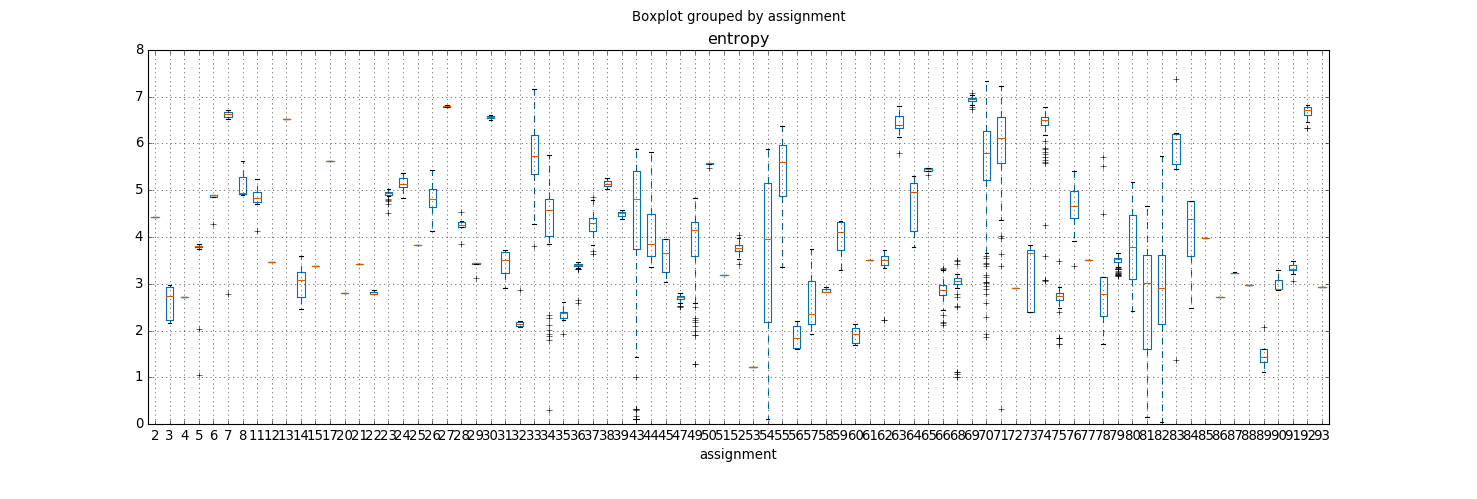

In [118]:
df.boxplot('entropy', by='assignment');

In [120]:
bya = df.groupby('assignment')

In [121]:
bya.groups[66]

Int64Index([2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042,
            ...
            2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337],
           dtype='int64', length=305)

In [122]:
bya.get_group(66)

assignment  blocksize charset charset0  cluster  \
2033          66        170   cp037    cp037        2   
2034          66        170   cp037    cp037        2   
2035          66        170   cp037    cp037        2   
2036          66        170   cp037    cp037        2   
2037          66        170   cp037    cp037        2   
2038          66        170   cp037    cp037        2   
2039          66        170   cp037    cp037        2   
2040          66        170   cp037    cp037        2   
2041          66        170   cp037    cp037        2   
2042          66        170   cp037    cp037        2   
2043          66        170   cp037    cp037        2   
2044          66        170   cp037    cp037        2   
2045          66        170   cp037    cp037        2   
2046          66        170   cp037    cp037        2   
2047          66        170   cp037    cp037        7   
2048          66        170   cp037    cp037        2   
2049          66        170   cp037    cp037        2   
2050          66        170   cp037    cp037        2   
2051          66        170   cp037    cp037        2   
2052          66        170   cp037    cp037        2   
2053          66        170   cp037    cp037        2   
2054          66        170   cp037    cp037        2   
2055          66        170   cp037    cp037        2   
2056          66        170   cp037    cp037        2   
2057          66        170   cp037    cp037        2   
2058          66        170   cp037    cp037        2   
2059          66        170   cp037    cp037        2   
2060          66        170   cp037    cp037        2   
2061          66        170   cp037    cp037        2   
2062          66        170   cp037    cp037        2   
...          ...        ...     ...      ...      ...   
2308          66        170   cp037    cp037        2   
2309          66        170   cp037    cp037        2   
2310          66        170   cp037    cp037        2   
2311          66        170   cp037    cp037        2   
2312          66        170   cp037    cp037        2   
2313          66        170   cp037    cp037        2   
2314          66        170   cp037    cp037        2   
2315          66        170   cp037    cp037        2   
2316          66        170   cp037    cp037        2   
2317          66        170   cp037    cp037        2   
2318          66        170   cp037    cp037        2   
2319          66        170   cp037    cp037        2   
2320          66        170   cp037    cp037        2   
2321          66        170   cp037    cp037        2   
2322          66        170   cp037    cp037        2   
2323          66        170   cp037    cp037        2   
2324          66        170   cp037    cp037        2   
2325          66        170   cp037    cp037        2   
2326          66        170   cp037    cp037        2   
2327          66        170   cp037    cp037        2   
2328          66        170   cp037    cp037        2   
2329          66        170   cp037    cp037        2   
2330          66        170   cp037    cp037        2   
2331          66        170   cp037    cp037        2   
2332          66        170   cp037    cp037        2   
2333          66        170   cp037    cp037        2   
2334          66        170   cp037    cp037        2   
2335          66        170   cp037    cp037        2   
2336          66        170   cp037    cp037        2   
2337          66        170   cp037    cp037        2   

                                                dataset   entropy  lengths  \
2033  ogo/ogo3/triaxial_search-coil_magnetometer/36p...  2.972352   171870   
2034  ogo/ogo3/triaxial_search-coil_magnetometer/36p...  2.856199   192780   
2035  ogo/ogo3/triaxial_search-coil_magnetometer/36p...  3.179894   155210   
2036  ogo/ogo3/triaxial_search-coil_magnetometer/36p...  3.212282   194990   
2037  ogo/ogo3/triaxial_search-coil_magnetometer/36p...  3.041012   197880   
203

In [123]:
j[2033]

{'blocks': 1011.0,
 'blocksize': 170,
 'bytefreqs': [[0, 59],
  [64, 4652],
  [194, 3],
  [195, 17],
  [196, 12],
  [197, 33],
  [198, 11],
  [199, 5],
  [200, 11],
  [201, 16],
  [75, 2],
  [76, 12],
  [211, 8],
  [212, 11],
  [213, 6],
  [214, 15],
  [215, 6],
  [217, 19],
  [96, 3],
  [226, 11],
  [227, 21],
  [229, 1],
  [230, 3],
  [231, 9],
  [168, 59],
  [233, 7],
  [193, 23],
  [107, 34],
  [108, 12],
  [240, 703],
  [241, 1037],
  [242, 387],
  [243, 510],
  [244, 523],
  [245, 510],
  [246, 397],
  [247, 293],
  [248, 302],
  [249, 245],
  [123, 1],
  [232, 11]],
 'charset': 'cp037',
 'left_over': 0,
 'len': 171870,
 'name': 'spdf.sci.gsfc.nasa.gov/pub/data/ogo/ogo3/triaxial_search-coil_magnetometer/36pt864-sec_averaged/DATA2_DR003282_DR003282_20080611_083054/dr003282_f00001.phys.1',
 'topbytes': ['40', 'f1', 'f0', 'f4', 'f3', 'f5', 'f6', 'f2', 'f8', 'f7'],
 'upperbitchars': []}

In [204]:
dsconvert(j[3083]['name'], 'cp037', 170, None)

In [201]:
dsconvert(j[3084]['name'], 'cp037', 170, None)

In [60]:
g = df.groupby('cluster')

In [79]:
g.groups

{0: Int64Index([   2,    3,    4,    5,    6,    7,    9,   10,   16,   31,
             ...
             5072, 5073, 5076, 5077, 5079, 5080, 5081, 5082, 5083, 5084],
            dtype='int64', length=1117),
 1: Int64Index([1147, 1148, 1149, 1150, 1151, 1152, 1201, 1202, 1221, 1250,
             ...
             4471, 4688, 5050, 5051, 5052, 5053, 5054, 5120, 5125, 5126],
            dtype='int64', length=585),
 2: Int64Index([1134, 1136, 1140, 1146, 1177, 1178, 1179, 1180, 1181, 1182,
             ...
             4449, 4456, 4469, 5041, 5046, 5066, 5068, 5116, 5117, 5134],
            dtype='int64', length=558),
 3: Int64Index([   1, 1200, 1205, 1206, 1207, 1299, 1300, 1301, 1523, 1527,
             ...
             2574, 2575, 2576, 3001, 3004, 4184, 4458, 5074, 5075, 5078],
            dtype='int64', length=193),
 4: Int64Index([1194, 1195, 1197, 1539, 1540, 1541, 1542, 1543, 1544, 1545,
             ...
             4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4679],
    

In [76]:
# First column really len. How to easily get right column name (actually multiindex) for len?
pd.concat([g['blocksize'].agg(len),  g[['blocksize', 'entropy','lengths']].agg([np.mean, np.std])], axis=1)

blocksize  (blocksize, mean)  (blocksize, std)  (entropy, mean)  \
cluster                                                                    
0             1117          60.555058        138.792979         0.302042   
1              585         205.656410        240.016737         0.702603   
2              558         116.268817        212.909770         0.626092   
3              193          93.170984         27.279166         0.459790   
4              548         106.401460         38.975539         0.399656   
5              371          41.175202         99.114970         0.823048   
6              857           5.623104         26.060929         0.252042   
7               35          15.742857         44.525830         0.606933   
8              517          58.119923        161.098076         0.487676   
9              355         166.191549         52.576578         0.362717   

         (entropy, std)  (lengths, mean)  (lengths, std)  
cluster                                                   
0              0.203699          1437636    5.498079e+06  
1              0.061918           970264    3.574263e+06  
2              0.106866           520252    2.231579e+06  
3              0.038578          1587714    8.178479e+06  
4              0.046119           187610    1.009794e+06  
5              0.049376           924256    2.986083e+06  
6              0.047782           210428    1.237410e+06  
7              0.018356         41610882    4.360782e+07  
8              0.110339          1731858    3.730193e+06  
9              0.032523          1115287    3.555804e+06

In [61]:
g[['blocksize', 'entropy','lengths']].agg([np.mean, np.std, len])

blocksize                     entropy                     lengths  \
               mean         std   len      mean       std     len      mean   
cluster                                                                       
0         60.555058  138.792979  1117  0.302042  0.203699  1117.0   1437636   
1        205.656410  240.016737   585  0.702603  0.061918   585.0    970264   
2        116.268817  212.909770   558  0.626092  0.106866   558.0    520252   
3         93.170984   27.279166   193  0.459790  0.038578   193.0   1587714   
4        106.401460   38.975539   548  0.399656  0.046119   548.0    187610   
5         41.175202   99.114970   371  0.823048  0.049376   371.0    924256   
6          5.623104   26.060929   857  0.252042  0.047782   857.0    210428   
7         15.742857   44.525830    35  0.606933  0.018356    35.0  41610882   
8         58.119923  161.098076   517  0.487676  0.110339   517.0   1731858   
9        166.191549   52.576578   355  0.362717  0.032523   355.0   1115287   

                             
                  std   len  
cluster                      
0        5.498079e+06  1117  
1        3.574263e+06   585  
2        2.231579e+06   558  
3        8.178479e+06   193  
4        1.009794e+06   548  
5        2.986083e+06   371  
6        1.237410e+06   857  
7        4.360782e+07    35  
8        3.730193e+06   517  
9        3.555804e+06   355

## Bytefreqs visualization

In [299]:
TOOLS="hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select,poly_select,lasso_select"
p = figure(tools=TOOLS, plot_width=1300)
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Id", "@id"),
    ("Name", "@dataset"),
    ("Entropy", "@entropy"),
    ("Assignment", "@assignment"),
    ("Charset", "@charset"),
    ("File size", "@lengths"),
    ("Blocksize", "@blocksize"),
    ("(x, y)", "($x, $y)"),
]

In [316]:
source = ColumnDataSource(dict(
    id=[i for i, r in enumerate(j)],
    x=reduced_data[:,0],
    y=reduced_data[:,1],
    dataset=[r['name'][32:120]  for r in j],
    entropy=entropy,
    # color=["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()([math.sqrt(b) for b in blocksizes]))],
    color=["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(assignments))],
    # color=["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()([c == 'cp037' for c in charsets]))],
    assignment=assignments,
    charset=charsets,
    lengths=lengths,
    blocksize=blocksizes))

In [317]:
p.title.text = "NASA datasets clustered by byte frequency, colored by assignment"
p.title.align = "center"
p.title.text_font_size = "25px"

In [318]:
p.scatter('x', 'y', color='color', source=source)
handle = show(p, notebook_handle=True)

In [ ]:
ass

In [314]:
push_notebook(handle=handle) # you can run to reflect later changes to p :)

In [120]:
df.ix[[5048]]

assignment  blocksize    charset  \
5048          83         30  iso8859-1   

                                                dataset   entropy   lengths  \
5048  ov/ov1-19/directional_proton_spectrometer/prot...  0.923243  12115948   

              x         y  
5048  23.839623  1.303948

In [48]:
j[5048]

{'blocks': 403864.93333333335,
 'blocksize': 30,
 'bytefreqs': [[0, 240],
  [1, 69],
  [2, 19],
  [3, 10],
  [4, 54],
  [5, 75],
  [6, 46],
  [7, 25],
  [8, 36],
  [9, 19],
  [10, 8],
  [11, 7],
  [12, 32],
  [13, 37],
  [14, 17],
  [15, 5],
  [16, 361],
  [17, 55],
  [18, 8],
  [19, 10],
  [20, 25],
  [21, 77],
  [22, 88],
  [23, 31],
  [24, 75],
  [25, 129],
  [26, 124],
  [27, 72],
  [28, 61],
  [29, 28],
  [30, 7],
  [31, 9],
  [32, 35],
  [33, 52],
  [34, 11],
  [35, 14],
  [36, 16],
  [37, 96],
  [38, 48],
  [39, 51],
  [40, 36],
  [41, 9],
  [42, 31],
  [43, 15],
  [44, 13],
  [45, 11],
  [46, 6],
  [47, 8],
  [48, 18],
  [49, 44],
  [50, 12],
  [51, 12],
  [52, 19],
  [53, 78],
  [54, 39],
  [55, 18],
  [56, 35],
  [57, 17],
  [58, 3],
  [59, 17],
  [60, 15],
  [61, 12],
  [62, 35],
  [63, 10],
  [64, 29],
  [65, 31],
  [66, 16],
  [67, 12],
  [68, 28],
  [69, 51],
  [70, 42],
  [71, 17],
  [72, 36],
  [73, 15],
  [74, 17],
  [75, 20],
  [76, 20],
  [77, 16],
  [78, 8],
  [79, 

In [284]:
j[4202]

{'blocks': 16457.0,
 'blocksize': 8,
 'bytefreqs': [[0, 1250],
  [32, 3750],
  [50, 1250],
  [52, 1250],
  [6, 1250],
  [57, 1250]],
 'charset': 'iso8859-1',
 'left_over': 0,
 'len': 131656,
 'name': 'spdf.sci.gsfc.nasa.gov/pub/data/ogo/ogo5/plasma_spectrometer/hi-res/dr003855/dr003855_f00003.indx',
 'topbytes': ['20', '00', '32', '34', '06', '39'],
 'upperbitchars': []}

## Alternative matplotlib plotting, but not interactive like bokeh

In [ ]:
fig, ax = plt.subplots()
reduced_data.plot(x=reduced_data[:, 0], y=reduced_data[:, 1], markersize=1, ax=ax)

In [187]:
rd = pd.DataFrame(reduced_data)

In [189]:
reduced_data

array([[ -4.7576,  -5.5728,   8.2598, ...,   0.1023,  -0.0204,  -0.0194],
       [ -6.2263,   8.4965,   1.8026, ...,   0.0643,   0.3043,   0.5146],
       [ -4.7503,  -0.4306,   0.4331, ...,  -0.0283,  -0.0125,   0.0023],
       ..., 
       [ 14.0298,   2.1248,   1.8277, ...,   0.0935,   0.0848,   0.1276],
       [  4.8401,   0.8299,   1.0542, ...,  -0.0062,  -0.0219,  -0.0573],
       [ -5.4851,   6.284 ,   1.8096, ...,  -0.0338,   0.3676,   0.2329]])

In [188]:
rd

0         1          2          3         4         5         6    \
0     -4.757570 -5.572779   8.259827   0.336236  1.684365  0.854346 -0.891338   
1     -6.226261  8.496543   1.802646  -4.491591 -0.549382  2.358504 -2.524250   
2     -4.750276 -0.430598   0.433097   0.098934 -0.686304 -1.403923  2.587131   
3     -4.747402 -0.428045   0.434074   0.097527 -0.685834 -1.402383  2.583690   
4     -4.735399 -0.417580   0.436534   0.130437 -0.686190 -1.413444  2.583499   
5     -4.735628 -0.417116   0.437276   0.132091 -0.685130 -1.413467  2.582792   
6     -4.743742 -0.423655   0.436395   0.113706 -0.684734 -1.393821  2.594987   
7     -4.744291 -0.426985   0.433375   0.107590 -0.683848 -1.390983  2.592329   
8     -5.047700  2.718370   1.189351  -0.411640 -0.806591 -0.942093  1.617316   
9     -4.747133 -0.425560   0.436172   0.110217 -0.683453 -1.398466  2.589019   
10    -4.747710 -0.426681   0.434258   0.109004 -0.685046 -1.398802  2.591186   
11    -4.991065  2.896650   1.256016  -0.319932 -0.761961 -0.970112  1.585867   
12    -5.287485  3.549022   1.308803  -1.059707 -0.811467 -0.656739  1.191393   
13    -5.295828  3.639375   1.312236  -1.104590 -0.808987 -0.574047  1.123522   
14    -5.113265  3.421030   1.335754  -0.657013 -0.762781 -0.784663  1.286819   
15    -5.262370  3.473112   1.289701  -1.002809 -0.810500 -0.647212  1.196033   
16    -4.592318  1.079505   0.989871   0.886581 -0.792022 -1.655592  2.642214   
17    -5.106483  3.394056   1.329932  -0.632697 -0.780218 -0.763240  1.299193   
18    -5.218352  3.375047   1.291069  -0.832654 -0.853443 -0.713255  1.283355   
19    -5.275925  3.475763   1.277482  -1.003197 -0.848093 -0.627011  1.216413   
20    -5.211431  3.261686   1.240238  -0.884112 -0.866520 -0.718027  1.280304   
21    -5.267459  3.580609   1.299902  -0.968976 -0.886202 -0.615059  1.113882   
22    -5.265062  3.466753   1.295106  -1.011049 -0.810357 -0.679863  1.216642   
23    -5.246098  3.549495   1.328837  -0.954198 -0.808819 -0.669680  1.266891   
24    -5.144345  2.936775   1.193298  -0.847187 -0.710690 -0.890434  1.508225   
25    -5.150004  2.705910   1.110472  -0.771541 -0.834233 -0.866724  1.515449   
26    -5.169885  3.220180   1.266070  -0.745064 -0.826437 -0.760843  1.332316   
27    -5.246270  3.526239   1.315173  -0.949173 -0.821384 -0.670859  1.192036   
28    -5.050979  3.273559   1.312672  -0.496039 -0.801985 -0.853140  1.348659   
29    -5.228230  3.499004   1.318387  -0.926006 -0.814156 -0.684546  1.232827   
...         ...       ...        ...        ...       ...       ...       ...   
5106  -4.431692 -7.965310  13.525833   2.028590  3.081201  1.719145 -3.577704   
5107  -4.382319 -7.905840  13.916142   2.401470  3.178360  2.226403 -3.548828   
5108   0.106144  5.997771   8.510460  15.108743  1.933290 -1.045568 -3.232765   
5109  -4.349389 -7.154605  12.645036   2.358810  2.828054  1.581312 -3.221448   
5110  -4.370122 -7.103263  12.674104   2.445655  2.827106  1.437166 -3.278543   
5111  -4.424202 -7.977833  13.618936   2.084915  3.099460  1.766567 -3.598418   
5112  -4.349389 -7.154605  12.645036   2.358810  2.828054  1.581312 -3.221448   
5113  -4.370122 -7.103263  12.674104   2.445655  2.827106  1.437166 -3.278543   
5114  -4.424202 -7.977833  13.618936   2.084915  3.099460  1.766567 -3.598418   
5115  13.392629  1.765004   1.231929   0.534454 -0.878607  0.151829  0.251284   
5116   4.807869  0.640961   0.966030   0.527634 -0.811903 -0.641362  1.717370   
5117   2.929112  0.180175   0.715829   0.185794 -0.874950 -0.526135  2.125503   
5118   2.304994  0.125071   0.819774   0.274448 -0.760387 -0.810890  1.858802   
5119  14.125958  1.964092   1.565219   1.148635 -0.771662  0.736919  0.553403   
5120   9.154310  1.555060   1.337941   1.264239 -0.908473 -0.271961  0.767418   
5121  14.529455  2.785231   1.816939   2.496901 -0.828011  0.901977  0.400492   
5122  15.501660  3.169565   1.909619   3.036759 -1.090183  1.127177  0.412025   
5123  15.889922  2.820411   1.706641   1.71

In [184]:
reduced_data.plot(x=reduced_data[:, 0], y=reduced_data[:, 1], markersize=1, ax=ax)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

TypeError: inner() got multiple values for argument 'ax'

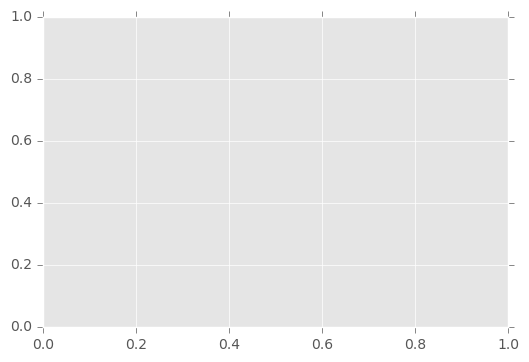

In [182]:
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=1, ax=ax)

<IPython.core.display.Javascript object>


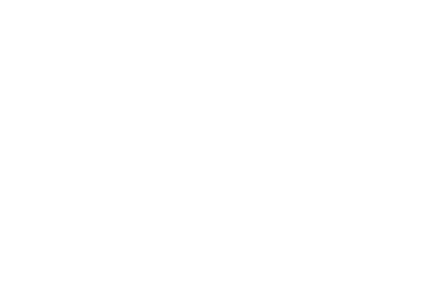

<IPython.core.display.Javascript object>


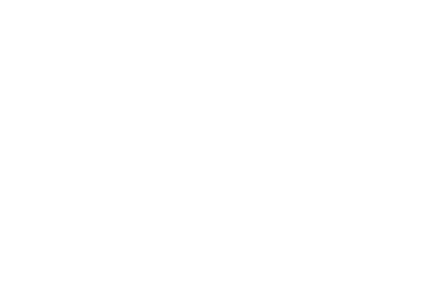

In [301]:
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=1)

In [154]:
reduced_data[[1,3]]

array([[-6.22537718,  8.49661398],
       [-4.7472415 , -0.42828793]])

In [ ]:
reduced_data[reduced_data]

In [151]:
reduced_data[:]

array([[-4.75714143, -5.57711364],
       [-6.22537718,  8.49661398],
       [-4.75011548, -0.43084069],
       [-4.7472415 , -0.42828793],
       [-4.73523743, -0.41782414],
       [-4.7354658 , -0.41736054],
       [-4.74358067, -0.42389963],
       [-4.74413047, -0.42722829],
       [-5.04728071,  2.71809007],
       [-4.74697219, -0.42580423]])

In [89]:
data = bfa #[-1000:]
k = 10

In [90]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [91]:
kmeans.cluster_centers_

array([[ -3.88445336,  -0.77017398],
       [  4.81590237,  -0.53473007],
       [ 15.51683444,   0.73626266],
       [ -4.06008665,  -6.46620622],
       [  0.76876019,  -1.00614677],
       [ -6.09853354,   9.28453385],
       [ -5.23927393,  -3.0695247 ],
       [  4.21319392,  16.09929744],
       [ -5.17670376,   3.55447611],
       [  9.07940731,   0.04559815]])

In [92]:
kmeans.verbose

0

In [133]:
unscaled = [[0, 0],
            [1, 2],
            [1, 1]]  # unscaled
unscaled

[[0, 0], [1, 2], [1, 1]]

In [134]:
scaled = scale(unscaled)
scaled

array([[-1.41421356, -1.22474487],
       [ 0.70710678,  1.22474487],
       [ 0.70710678,  0.        ]])

In [199]:
list(enumerate(kmeans.cluster_centers_))

[(0, array([-5.23927393, -3.06952989])),
 (1, array([ 9.0680251 ,  0.04735958])),
 (2, array([-5.17670376,  3.55447241])),
 (3, array([ 4.80485266, -0.53969852])),
 (4, array([  4.21319395,  16.09927272])),
 (5, array([-3.88445336, -0.77018258])),
 (6, array([ 15.51683444,   0.73625909])),
 (7, array([-4.06008665, -6.46620001])),
 (8, array([-6.09853354,  9.28456191])),
 (9, array([ 0.76876019, -1.00612759]))]

In [197]:
list(enumerate(centroids))

[(0, array([-4.06008665, -6.46620913])),
 (1, array([ 9.0602425 ,  0.04995034])),
 (2, array([-5.17670376,  3.55450713])),
 (3, array([ 0.74534148, -1.01700492])),
 (4, array([-3.88649677, -0.76917142])),
 (5, array([ 15.51683444,   0.736282  ])),
 (6, array([-6.09853354,  9.28448325])),
 (7, array([ 4.7790276 , -0.54028762])),
 (8, array([  4.21319392,  16.09924845])),
 (9, array([-5.23927394, -3.06953801]))]

Looks like centroid 4 is ebcdic

[4] [-4.75714144 -5.57708407] cp037 spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/DATA2_DR002945_DR002945_20080611_083040/dr002945_f00001.phys.1
[3] [-6.22537718  8.49663141] iso8859-1 spdf.sci.gsfc.nasa.gov/pub/data/explorer/explorer31/plasma_cep/dmea_ne_te.asc
[0] [-4.74697219 -0.42580704] iso8859-1 spdf.sci.gsfc.nasa.gov/pub/data/explorer/explorer31/plasma_ims/ion_composition_density/NSSX1398807953/DR00391900008.dat


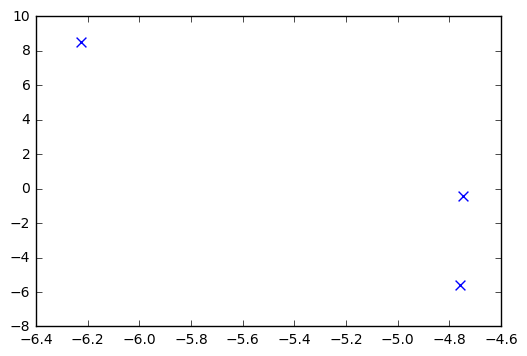

In [187]:
showpoints(reduced_data, [0,1,9])

In [149]:
scaler.transform(bfa_unscaled[0:1])

array([[ -0.75252716,  -0.62514063,  -0.75530772,  -0.64838441,
         -0.64898103,  -0.57363654,  -0.51790342,  -0.61774693,
         -0.60107906,  -0.41607263,  -0.3391323 ,  -0.44030799,
         -0.39179996,  -0.51995473,  -0.47764494,  -0.45076935,
         -0.34875729,  -0.50724793,  -0.43185239,  -0.46039991,
         -0.38813836,  -0.46443042,  -0.35834098,  -0.45805209,
         -0.30030134,  -0.42274134,  -0.4156198 ,  -0.4558193 ,
         -0.39863201,  -0.444379  ,  -0.25222016,  -0.37542946,
         -0.52006144,  -0.33955513,  -0.33864631,  -0.36336268,
         -0.24684456,  -0.38974959,  -0.34161664,  -0.35716489,
         -0.31692771,  -0.35863817,  -0.32654672,  -0.35511799,
         -0.30916134,  -0.49964096,  -0.55252394,  -0.39225694,
         -0.53214601,  -0.51621961,  -0.47754624,  -0.49655083,
         -0.54269745,  -0.57296253,  -0.5389704 ,  -0.45155984,
         -0.35603743,  -0.42754253,  -0.3356609 ,  -0.34535513,
         -0.28097302,  -0.33289958,  -0.

In [61]:
predictions = kmeans.predict(reduced_data)

In [66]:
topbytes[predictions == 5]

TypeError: only integer arrays with one element can be converted to an index

In [70]:
predictions.shape

(5136,)

In [89]:
samples = [np.random.choice(np.where([predictions ==i])[1], 5) for i in range(k)]

In [90]:
samples[0]

array([274, 475, 848, 270,  47])

In [96]:
fullname(j[0]['name'])

'/srv/bs/mirror/nasa/spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/DATA2_DR002945_DR002945_20080611_083040/dr002945_f00001.phys.1'

In [121]:
for p in range(k):
    print("Cluster %d, centroid %s" % (p, centroids[p]))
    for i in samples[p]:
        print("  ", ' '.join(topbytes[i]), " ", labels[i][:200])
        # print(show(labels[i]))

Cluster 0, centroid [-5.17097762  3.53207826]
   20 30 2e 31 34 32 33 35 36 37   explorer/explorer31/plasma_ims/ion_composition_density/NSSX1398807953/DR00391900273.dat
   20 30 2e 31 34 32 33 37 38 36   explorer/explorer31/plasma_ims/ion_composition_density/NSSX1398807953/DR00391900474.dat
   20 30 2e 31 33 32 34 39 37 36   explorer/explorer31/plasma_ims/ion_composition_density/NSSX1398807953/DR00391900847.dat
   20 30 2e 31 32 37 33 35 34 36   explorer/explorer31/plasma_ims/ion_composition_density/NSSX1398807953/DR00391900269.dat
   20 30 2e 31 34 37 32 36 38 35   explorer/explorer31/plasma_ims/ion_composition_density/NSSX1398807953/DR00391900046.dat
Cluster 1, centroid [ 9.05859559  0.05004215]
   00 6a e0 ff 20 02 04 09 08 97   imp/imp2/cosmic-ray_range_vs_energy_loss/reduced_cosmic-ray_count_accumulation/DATA2_DR003103_DR003103_20080611_083044/dr003103_f00026.phys.1
   00 01 e5 38 aa f2 f1 04 02 39   imp/imp4/cosmic-ray_proton_r_vs_dedx/telescope_accumulator_readings/DATA3_DR00354

In [87]:
np.set_printoptions(linewidth=160)

In [88]:
np.where([predictions ==5])[1]

array([   0, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1186, 1203, 1204, 1308, 1309, 1310, 1311, 2082, 2083, 2084, 2085, 2086, 2413, 3002, 3005, 3007, 3013,
       3014, 3015, 3016, 3017, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3098, 3100, 3101, 3102, 3103, 3104, 3105,
       3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3125, 3126, 3127, 3128, 3129, 3130, 3131,
       3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156,
       3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3176, 3177, 3178, 3179, 3180, 3181, 3182,
       3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207,
       3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 321

In [69]:
np.argwhere([predictions == 5])

array([[   0,    0],
       [   0, 1126],
       [   0, 1127],
       [   0, 1128],
       [   0, 1129],
       [   0, 1130],
       [   0, 1131],
       [   0, 1132],
       [   0, 1186],
       [   0, 1203],
       [   0, 1204],
       [   0, 1308],
       [   0, 1309],
       [   0, 1310],
       [   0, 1311],
       [   0, 2082],
       [   0, 2083],
       [   0, 2084],
       [   0, 2085],
       [   0, 2086],
       [   0, 2413],
       [   0, 3002],
       [   0, 3005],
       [   0, 3007],
       [   0, 3013],
       [   0, 3014],
       [   0, 3015],
       [   0, 3016],
       [   0, 3017],
       [   0, 3083],
       [   0, 3084],
       [   0, 3085],
       [   0, 3086],
       [   0, 3087],
       [   0, 3088],
       [   0, 3089],
       [   0, 3090],
       [   0, 3091],
       [   0, 3092],
       [   0, 3093],
       [   0, 3094],
       [   0, 3095],
       [   0, 3096],
       [   0, 3098],
       [   0, 3100],
       [   0, 3101],
       [   0, 3102],
       [   0,

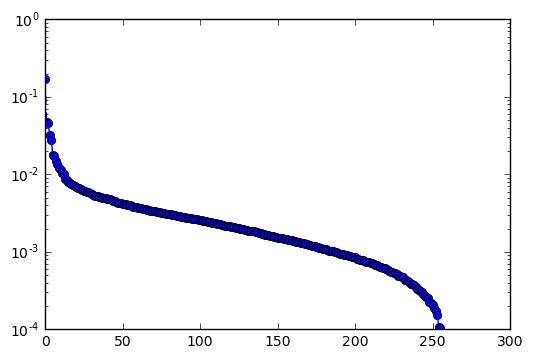

In [127]:
pca = PCA().fit(data)
reduced_data = pca.transform(data)
plt.semilogy(pca.explained_variance_ratio_, '--o')

In [131]:
# use seaborn to help somehow, from http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/
sns.heatmap(np.log(pca_trafo.inverse_transform(np.eye(data.shape[1]))), cmap="hot", cbar=False)

NameError: name 'sns' is not defined

In [130]:
pca.components_

array([[ 0.016763  , -0.0001613 ,  0.0100272 , ...,  0.08982891,  0.08146281,  0.0487117 ],
       [-0.02786665, -0.09095848, -0.08852882, ..., -0.00611884, -0.00288985, -0.02139095],
       [-0.07092429, -0.14299041, -0.1500322 , ..., -0.00559235, -0.00486121, -0.02739454],
       ..., 
       [ 0.01295701, -0.0021637 ,  0.00140575, ...,  0.00278547, -0.00658485,  0.01003085],
       [ 0.01369229, -0.02187832,  0.02861104, ..., -0.00131074,  0.00523176,  0.00625681],
       [-0.00780576, -0.01162991,  0.01211396, ...,  0.00681381,  0.01698222,  0.00535421]])

In [160]:
axis=0
topx = np.argmax(pca.components_[axis,:])
print("axis %d: byte value %s has largest component of %.4f" % (axis, hex(topx), pca.components_[axis, topx]))
botx = np.argmin(pca.components_[axis,:])
print("axis %d: byte value %s has smallest component of %.4f" % (axis, hex(botx), pca.components_[axis, botx]))

axis 0: byte value 0x75 has largest component of 0.1141
axis 0: byte value 0x20 has smallest component of -0.0587


In [149]:
# show as 16x16 array, times 100, with less precision
pca.components_[axis,:]

array([ 0.0168, -0.0002,  0.01  ,  0.0005,  0.0069, -0.0141, -0.0235, -0.0121, -0.0051, -0.0225, -0.0326,  0.0637,  0.0155,  0.0342,  0.0301,  0.0305,
       -0.0333, -0.0006,  0.0197,  0.0213,  0.0171,  0.0235,  0.0305,  0.0232,  0.0242,  0.0356,  0.0348,  0.0447,  0.0311,  0.0395,  0.0192,  0.0309,
       -0.0587,  0.0168,  0.0195,  0.027 , -0.0116,  0.0219,  0.0191,  0.0291,  0.0213,  0.0272,  0.0225,  0.0009,  0.0125, -0.0213, -0.0541,  0.0251,
       -0.054 , -0.0469, -0.0413, -0.0374, -0.0413, -0.0532, -0.0364, -0.0371, -0.0297, -0.0295,  0.023 , -0.0294,  0.0138,  0.0391,  0.0436,  0.0531,
       -0.0162,  0.0291,  0.0566,  0.064 ,  0.0575, -0.0154,  0.0635,  0.0677,  0.0869,  0.0397,  0.0614,  0.0166,  0.0412,  0.0453,  0.0121,  0.0323,
        0.0277,  0.0501,  0.0286,  0.0485,  0.0369,  0.0638,  0.0586,  0.0876,  0.0659,  0.0914,  0.0624,  0.0627,  0.0849,  0.0853,  0.0561,  0.0421,
        0.0128,  0.0317,  0.0487,  0.0665,  0.0657,  0.0685,  0.0519,  0.0947,  0.0901,  0.103

In [159]:
axis=1
topx = np.argmax(pca.components_[axis,:])
print("axis %d: byte value %s has largest component of %.4f" % (axis, hex(topx), pca.components_[axis, topx]))
botx = np.argmin(pca.components_[axis,:])
print("axis %d: byte value %s has smallest component of %.4f" % (axis, hex(botx), pca.components_[axis, botx]))

axis 1: byte value 0x30 has largest component of 0.2042
axis 1: byte value 0xf6 has smallest component of -0.1433


In [156]:
# show as 16x16 array, times 100, with less precision
pca.components_[axis,:]

array([-0.0279, -0.091 , -0.0885, -0.0991, -0.0919, -0.0986, -0.0953, -0.102 , -0.0934, -0.0846, -0.0782, -0.0211, -0.0286, -0.031 , -0.0351, -0.0251,
       -0.0699, -0.0467, -0.0296, -0.0269, -0.0217, -0.0263, -0.0297, -0.0262, -0.0032, -0.0186, -0.0079, -0.0196, -0.0181, -0.0185, -0.0136, -0.0149,
        0.1458, -0.0195, -0.0159, -0.0155,  0.0936, -0.0172, -0.0124, -0.0128, -0.0102, -0.0081, -0.008 ,  0.0787, -0.0118,  0.1504,  0.1868,  0.0266,
        0.2042,  0.2021,  0.1908,  0.1916,  0.1716,  0.0616,  0.1821,  0.174 ,  0.1668,  0.1545, -0.0042, -0.0683,  0.0412,  0.0102,  0.072 ,  0.0012,
       -0.1319,  0.1503,  0.0279,  0.0836,  0.0958,  0.2025,  0.0817,  0.0729,  0.071 ,  0.116 ,  0.023 , -0.0283,  0.0863,  0.119 ,  0.0314,  0.0872,
        0.0974,  0.0685,  0.1246,  0.1343,  0.1353,  0.1006,  0.0468,  0.029 ,  0.0095,  0.0489,  0.029 ,  0.0063,  0.0036,  0.0068,  0.0021,  0.1068,
       -0.0604,  0.0102,  0.0248,  0.0334,  0.0521,  0.0665,  0.0301,  0.0271,  0.0327,  0.030

In [128]:
pca.explained_variance_ratio_

array([  1.70783467e-01,   4.73100975e-02,   4.60565473e-02,   3.20424167e-02,   2.80096355e-02,   1.75597252e-02,   1.71336980e-02,   1.47615085e-02,
         1.37999024e-02,   1.21595728e-02,   1.14490141e-02,   1.02960645e-02,   1.01027433e-02,   8.69493257e-03,   8.45258087e-03,   8.01936965e-03,
         7.80865168e-03,   7.59307061e-03,   7.32625118e-03,   7.19084918e-03,   6.96854472e-03,   6.75033077e-03,   6.59412135e-03,   6.51370384e-03,
         6.33900718e-03,   6.17052166e-03,   6.07792591e-03,   5.94526516e-03,   5.86775830e-03,   5.78707913e-03,   5.61893108e-03,   5.48466918e-03,
         5.34632981e-03,   5.24478591e-03,   5.19709184e-03,   5.16344342e-03,   5.10395167e-03,   4.98846236e-03,   4.96792277e-03,   4.90945805e-03,
         4.86218569e-03,   4.81796013e-03,   4.75128153e-03,   4.64397978e-03,   4.60149428e-03,   4.58996559e-03,   4.38120982e-03,   4.33993355e-03,
         4.30315532e-03,   4.27197641e-03,   4.15160469e-03,   4.11223161e-03,   4.09471662e-0

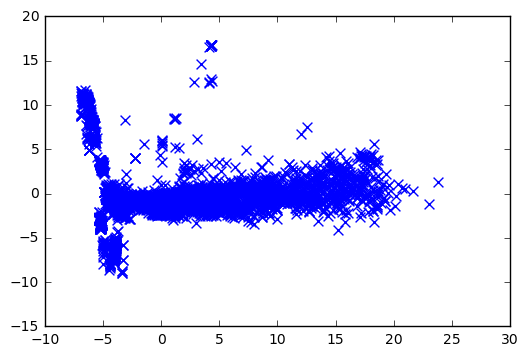

In [60]:
showpoints(reduced_data, range(len(reduced_data)))

[(8, 35, array([  4.21149091,  16.10074158])),
 (6, 186, array([-6.09947265,  9.28431581])),
 (2, 864, array([-5.17719506,  3.55475297])),
 (3, 371, array([ 15.51461402,   0.7368569 ])),
 (1, 585, array([ 9.05146808,  0.04742115])),
 (7, 563, array([ 4.75932422, -0.54338007])),
 (0, 1117, array([-3.88626453, -0.7704051 ])),
 (4, 512, array([ 0.73239372, -1.0170043 ])),
 (5, 548, array([-5.23983653, -3.07140172])),
 (9, 355, array([-4.06060809, -6.46116145]))]


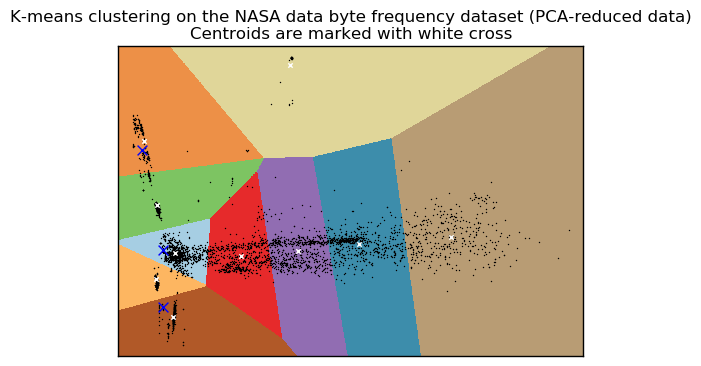

In [124]:
# FIXME: make this a function
data = bfa #[-1000:]
k = 10

pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02

# Bounding box for plot of points in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

# Plot the decision boundary. For that, we will assign a color to each
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=1)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=10, linewidths=1,
            color='w', zorder=10)
plt.title('K-means clustering on the NASA data byte frequency dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

showpoints(reduced_data, [0,1,9])

# FIXME: identify some "type indicator" datasets that lie near the centroids and use them to label the centroids
# FIXME: do kmeans in full dimensionality??
cs = []
prediction_counts = collections.Counter(kmeans.predict(reduced_data))
for i, centroid in enumerate(centroids):
    cs.append((i, prediction_counts[i], centroid))

cs.sort(key=lambda t:t[2][1], reverse=True)
pprint(cs)
plt.show()

In [263]:
temp = sys.stdout

In [31]:
range(len(reduced_data))

range(0, 5136)

In [ ]:
def clusterMatch(data, indices):
    

In [251]:
euclid = DistanceMetric.get_metric('euclidean')

In [252]:
euclid.pairwise?

In [ ]:
DistanceMetric.get_metric('euclidean').pairwise

In [233]:
kmeans.predict([reduced_data[0]])[0], reduced_data[0]

(5, array([-4.75714143, -5.57710177]))

In [236]:
kmeans.cluster_centers_[5]

array([-4.06008665, -6.46621022])

In [ ]:
with open('/srv/neal/info/astro/nasamoon', 'w') as f:
    print([], file=f)

[0] [-4.75714143 -5.57708678] cp037 spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/DATA2_DR002945_DR002945_20080611_083040/dr002945_f00001.phys.1
[2] [-6.22537718  8.49662619] iso8859-1 spdf.sci.gsfc.nasa.gov/pub/data/explorer/explorer31/plasma_cep/dmea_ne_te.asc
[3] [-4.74697219 -0.4258003 ] iso8859-1 spdf.sci.gsfc.nasa.gov/pub/data/explorer/explorer31/plasma_ims/ion_composition_density/NSSX1398807953/DR00391900008.dat
[(8, 35, array([  4.21319393,  16.09931529])),
 (2, 186, array([-6.09853354,  9.28456434])),
 (6, 864, array([-5.17670376,  3.55446315])),
 (4, 371, array([ 15.51683444,   0.73625115])),
 (9, 583, array([ 9.07940731,  0.04562288])),
 (1, 559, array([ 4.81590237, -0.53473559])),
 (3, 1118, array([-3.88445336, -0.77017597])),
 (7, 518, array([ 0.76876019, -1.00616756])),
 (5, 548, array([-5.23927393, -3.06950391])),
 (0, 355, array([-4.06008665, -6.46620753]))]


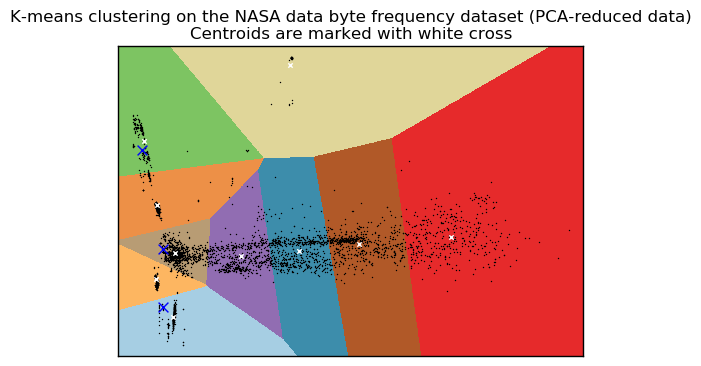

In [227]:
# dup
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02

# Bounding box for plot of points in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

# Plot the decision boundary. For that, we will assign a color to each
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=1)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=10, linewidths=1,
            color='w', zorder=10)
plt.title('K-means clustering on the NASA data byte frequency dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

showpoints(reduced_data, [0,1,9])

cs = []
prediction_counts = collections.Counter(kmeans.predict(reduced_data))
for i, centroid in enumerate(centroids):
    cs.append((i, prediction_counts[i], centroid))

cs.sort(key=lambda t:t[2][1], reverse=True)
pprint(cs)
plt.show()


In [203]:
prediction_counts = collections.Counter(kmeans.predict(reduced_data))

In [206]:
for i, centroid in enumerate(centroids):
    print(i, prediction_counts[i], centroid)

0 548 [-5.23927393 -3.06952763]
1 560 [ 4.79773471 -0.54115973]
2 864 [-5.17670376  3.55448872]
3 371 [ 15.51683444   0.73627379]
4 515 [ 0.75628543 -1.00809954]
5 1118 [-3.88649677 -0.76916838]
6 35 [  4.21319393  16.09926291]
7 186 [-6.09853354  9.28451268]
8 355 [-4.06008665 -6.46620693]
9 585 [ 9.0680251   0.04735729]


In [204]:
prediction_counts

Counter({0: 548,
         1: 560,
         2: 864,
         3: 371,
         4: 515,
         5: 1118,
         6: 35,
         7: 186,
         8: 355,
         9: 585})

In [205]:
centroids

array([[ -5.23927393,  -3.06952763],
       [  4.79773471,  -0.54115973],
       [ -5.17670376,   3.55448872],
       [ 15.51683444,   0.73627379],
       [  0.75628543,  -1.00809954],
       [ -3.88649677,  -0.76916838],
       [  4.21319393,  16.09926291],
       [ -6.09853354,   9.28451268],
       [ -4.06008665,  -6.46620693],
       [  9.0680251 ,   0.04735729]])

In [113]:
pca = PCA(n_components=2).fit(data)

In [114]:
pt = pca.transform(data)

In [95]:
x_min

-7.8951957592668176

In [96]:
len(xx)

1389

In [98]:
Z.size

2273793

In [104]:
xx.shape

(1389, 1637)

In [103]:
xx[:3,:3]

array([[-7.89519576, -7.87519576, -7.85519576],
       [-7.89519576, -7.87519576, -7.85519576],
       [-7.89519576, -7.87519576, -7.85519576]])

In [105]:
np.arange(3, 5, .1)

array([ 3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,
        4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9])

In [106]:
np.meshgrid(np.arange(0, 1, .5), np.arange(5, 6, .3)

[array([[ 0. ,  0.5],
        [ 0. ,  0.5],
        [ 0. ,  0.5],
        [ 0. ,  0.5]]), array([[ 5. ,  5. ],
        [ 5.3,  5.3],
        [ 5.6,  5.6],
        [ 5.9,  5.9]])]

In [111]:
bfa_unscaled[0]

array([    0.,    25.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
        4872.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,   895.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
      

In [124]:
bfa_unscaled[:1]

array([[    0.,    25.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         4872.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   895.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

In [139]:
# But how to re-scale new data the same way? This just results in zeros.
exd = scale(bfa_unscaled[:1,:])

In [138]:
exd

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0., -1., -1.,  0., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        -1., -1., -1.,  0., -1., -1., -1.,  0.,  0., -1.,  1., -1., -1.,
        -1., -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [123]:
pca.transform(exd)

array([[  3.17962033e-15,   1.34943258e-15]])

In [110]:
centroids[:, 1]
 

array([ -0.76916977,   0.73627109,   3.55448343,  -0.54546745,
         9.28452962,   0.04968753,  -6.46621081,  -3.0695277 ,
        16.09922242,  -1.01751045])

In [ ]:
plt.scatter(ex[:, 0], ex[:, 1],
            marker='x', s=50, linewidths=1,
            color='w', zorder=10)

# ETL decimal point marker detection for DR2129

with open('../dr002129_f00001.phys.1', 'rt', encoding='cp500') as f:
    d2129e = f.read()

In [70]:
len(d2129e)

3270980

In [221]:
for c in " -.0Aa": print("%s %d" % (c, ord(c)))

  32
- 45
. 46
0 48
A 65
a 97


In [222]:
d=d2129c

In [226]:
d[:,6]

array([b' ', b' ', b'.', ..., b'.', b' ', b'.'], 
      dtype='|S1')

In [ ]:
np.where()

In [237]:
cols_with_decimalpoints = [i for i,v in enumerate(col_has_decimalpoints)  if v]

In [239]:
len(cols_with_decimalpoints)

66

In [240]:
str(cols_with_decimalpoints)

'[5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 19, 20, 21, 25, 29, 30, 33, 35, 36, 40, 41, 44, 45, 47, 48, 50, 51, 52, 55, 56, 60, 63, 65, 67, 69, 70, 73, 75, 79, 80, 83, 85, 89, 90, 93, 95, 99, 100, 103, 105, 106, 110, 111, 115, 116, 120, 124, 125, 126, 130, 132, 135, 136, 140, 145, 150]'

In [236]:
col_has_decimalpoints = [any(d[:,col] == b'.') for col in range(d.shape[1])]

In [244]:
d[:,col_has_decimalpoints][:5]

/home/neal/Envs/hug/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


array([[b'', b'', b'', b'', b'', b's', b's', b's', b'', b's', b's', b'',
        b's', b's', b's', b's', b's', b'', b'', b's', b's', b's', b'', b'',
        b'', b's', b'', b'', b'', b's', b's', b'', b'', b's', b'', b's',
        b's', b'', b'', b'', b's', b's', b'', b'', b's', b's', b'', b's',
        b's', b'', b's', b's', b's', b'', b'', b's', b's', b'', b'', b'',
        b's', b'', b'', b's', b'', b's', b'', b's', b'', b's', b's', b'',
        b'', b's', b'', b's', b'', b'', b'', b's', b's', b'', b'', b's',
        b'', b's', b'', b'', b'', b's', b's', b'', b'', b's', b'', b's',
        b'', b'', b'', b's', b's', b'', b'', b's', b'', b's', b's', b'',
        b'', b'', b's', b's', b'', b'', b'', b's', b's', b'', b'', b'',
        b's', b'', b'', b'', b's', b's', b's', b'', b'', b'', b's', b'',
        b's', b'', b'', b's', b's', b'', b'', b'', b's', b'', b'', b'',
        b'', b's', b'', b'', b'', b'', b's', b'', b'', b'', b'', b'', b'',
        b'', b'', b'', b'', b'', b'', b''],
 

In [123]:
d2129c = np.array(d2129e, 'c')
d2129c.shape = (-1, 164)
d2129f = d2129c.view(np.uint8).astype(np.float)

In [252]:
d2129c[1:2][:,cols_with_decimalpoints]

array([[b'.', b' ', b' ', b'5', b'.', b'3', b'.', b' ', b'2', b'.', b'.',
        b'2', b'0', b'.', b' ', b' ', b'.', b'8', b'1', b'.', b'5', b'7',
        b'.', b'0', b'.', b'2', b'.', b'8', b'0', b'.', b'.', b'2', b'0',
        b'.', b' ', b' ', b'.', b' ', b'.', b'7', b'.', b' ', b'.', b'7',
        b'.', b' ', b'.', b'0', b'.', b'3', b' ', b'.', b' ', b'.', b' ',
        b'.', b'.', b'0', b'0', b'.', b'0', b'1', b'.', b' ', b' ', b' ']], 
      dtype='|S1')

In [250]:
d2129c[1:2]

array([[b'', b's', b' ', b' ', b'1', b'.', b' ', b' ', b'1', b'5', b'.',
        b' ', b'3', b'.', b' ', b'2', b'.', b'2', b'3', b'.', b'2', b'0',
        b' ', b'-', b'1', b'.', b'3', b'5', b'7', b' ', b' ', b'6', b'9',
        b'.', b'5', b'8', b'1', b'5', b'0', b'6', b'.', b'5', b' ', b' ',
        b'7', b'.', b'4', b'0', b'.', b'4', b'2', b'.', b'8', b'0', b'1',
        b'0', b'.', b'9', b' ', b'3', b'.', b'6', b'7', b'2', b'1', b'0',
        b'0', b'.', b'0', b' ', b' ', b'2', b'0', b'.', b'9', b' ', b'-',
        b'1', b'5', b'.', b'7', b' ', b'0', b'.', b'0', b' ', b'-', b'1',
        b'5', b'.', b'7', b' ', b'0', b'.', b'0', b' ', b'2', b'8', b'3',
        b'.', b'0', b' ', b'0', b'.', b'9', b'3', b' ', b' ', b' ', b'0',
        b'.', b' ', b' ', b' ', b'0', b'.', b' ', b'4', b'9', b'8', b'.',
        b'1', b'0', b'0', b'.', b'0', b'0', b'1', b'0', b'0', b'.', b'0',
        b'0', b' ', b' ', b'1', b'.', b'4', b'8', b' ', b' ', b' ', b' ',
        b' ', b' ', b' ', b' ', b' ', b

In [136]:
t = d2129c[:5]

In [142]:
t.view('S82')[:,0]

array([ b'\x00s                 131    4                 MAD                     0             ',
       b'\x00s  1.  15. 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 ',
       b'\x00s  10. 3. 2.26.70 -1.577  69.605506.6  7.40.51.8010.9 3.672100.0  20.9 -10.4 0.0 ',
       b'\x00s  2.  15. 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 ',
       b'\x00s  10. 3. 2.54.60 -3.336  69.792507.6  7.42. 4.6010.8 3.762100.0  20.9 -10.5 0.0 '], 
      dtype='|S82')

In [141]:
t.view('S164')[:,0]

array([ b'\x00s                 131    4                 MAD                     0                                                                                     0000000000',
       b'\x00s  1.  15. 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.7 0.0 283.0 0.93   0.   0. 498.100.00100.00  1.48                   000000',
       b'\x00s  10. 3. 2.26.70 -1.577  69.605506.6  7.40.51.8010.9 3.672100.0  20.9 -10.4 0.0 -10.4 0.0 283.0 0.93   0.   0. 498.100.00100.00  1.48448 66 66 66 66 55 78  000000',
       b'\x00s  2.  15. 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.8 0.0 279.0 0.93   0.   0. 509.100.00100.00  1.44                   000000',
       b'\x00s  10. 3. 2.54.60 -3.336  69.792507.6  7.42. 4.6010.8 3.762100.0  20.9 -10.5 0.0 -10.5 0.0 278.0 0.93   0.   0. 509.100.00100.00  1.44455 67 67 67 67 55 79  000000'], 
      dtype='|S164')

In [132]:
charar = np.chararray((3,))

In [133]:
charar[:] = 'a'

In [134]:
charar

chararray([b'a', b'a', b'a'], 
      dtype='|S1')

In [135]:
np.core.defchararray.join('', charar)

TypeError: sequence item 0: expected str instance, int found

In [131]:
np.core.defchararray.join('', d2129c[:3])

TypeError: sequence item 0: expected str instance, int found

In [119]:
d2129c = np.array(d2129e, 'c')
d2129f = d2129c.view(np.uint8).astype(np.float)

In [122]:
d2129c[:5]

array([b'', b's', b' ', b' ', b' '], 
      dtype='|S1')

In [96]:
d2129f.shape = (-1, 164)

In [98]:
d2129f.shape

(19945, 164)

In [97]:
d2129f

array([[   0.,  115.,   32., ...,   48.,   48.,   48.],
       [   0.,  115.,   32., ...,   48.,   48.,   48.],
       [   0.,  115.,   32., ...,   48.,   48.,   48.],
       ..., 
       [   0.,  115.,   32., ...,   32.,   48.,   48.],
       [   0.,  115.,   32., ...,   32.,   48.,   48.],
       [   0.,  115.,   32., ...,   32.,   48.,   48.]])

# Look for clusters that stand out on various measures

Apply lessons from transformation section of http://pandas.pydata.org/pandas-docs/stable/groupby.html
but getting all sd 1.0....
somehow need to transform whole thing, then look at difference by cluster.

In [153]:
zscore = lambda x: (x - x.mean()) / x.std()

In [167]:
dfn = g.transform(zscore)
dfn['cluster'] = df.cluster

In [162]:
dfn

assignment  blocksize   entropy   lengths         x         y  cluster
0      -4.492762   4.523087 -0.730761  1.146667 -2.614566  1.332822        3
1      -4.244998   0.819294 -1.303892  0.600619 -0.109772 -0.562872        5
2      -1.727443  -0.429093 -1.316449 -0.261167 -1.093376  0.573227        1
3      -1.727443  -0.429093 -1.316989 -0.261167 -1.089739  0.577533        1
4      -1.727443  -0.429093 -1.315385 -0.261167 -1.074550  0.595186        1
5      -1.727443  -0.429093 -1.316813 -0.261167 -1.074839  0.595968        1
6      -1.727443  -0.429093 -1.317703 -0.261167 -1.085107  0.584938        1
7      -1.727443  -0.429093 -1.312877 -0.261167 -1.085802  0.579320        1
8      -0.243141  -0.196501 -1.089111 -0.151127  0.231685 -1.358429        4
9      -1.727443  -0.429093 -1.320171 -0.261167 -1.089398  0.581725        1
10     -1.727443  -0.429093 -1.315600 -0.261167 -1.090129  0.579833        1
11     -0.243141  -0.196501 -0.946543 -0.153507  0.333013 -1.068871        4
12     -0.243141  -0.196501  0.021749 -0.098606 -0.197325 -0.009309        4
13     -0.243141  -0.196501  0.074170 -0.102083 -0.212251  0.137440        4
14     -0.243141  -0.196501 -0.279933 -0.123585  0.114379 -0.217190        4
15     -0.243141  -0.196501 -0.044707 -0.113886 -0.152391 -0.132599        4
16     -1.727443  -0.429093 -1.123764 -0.258694 -0.893486  3.120637        1
17     -0.243141  -0.196501 -0.244959 -0.121115  0.126513 -0.261000        4
18     -0.243141  -0.196501 -0.107671 -0.125782 -0.073636 -0.291874        4
19     -0.243141  -0.196501 -0.007012 -0.048189 -0.176641 -0.128294        4
20     -0.243141  -0.196501 -0.298124 -0.088907 -0.061253 -0.475992        4
21     -0.243141  -0.196501  0.123781 -0.076279 -0.161496  0.041993        4
22     -0.243141  -0.196501 -0.073651 -0.078658 -0.157207 -0.142927        4
23     -0.243141  -0.196501 -0.010017 -0.072253 -0.123276 -0.008541        4
24     -0.243141  -0.196501 -0.959167 -0.137219  0.058774 -1.003702        4
25     -0.243141  -0.196501 -0.965019 -0.137219  0.048649 -1.378667        4
26     -0.243141  -0.196501 -0.377977 -0.106567  0.013078 -0.543404        4
27     -0.243141  -0.196501 -0.004815 -0.069233 -0.123586 -0.046312        4
28     -0.243141  -0.196501 -0.381350 -0.106567  0.225819 -0.456707        4
29     -0.243141  -0.196501 -0.087606 -0.054959 -0.091308 -0.090547        4
...          ...        ...       ...       ...       ...       ...      ...
5106    1.939304  -0.840518  1.839555  0.330382 -1.392075 -2.256626        3
5107    1.939304  -0.840518  1.608903  0.331961 -1.206858 -2.167403        3
5108    5.736689   4.138384  7.666363  4.754042  9.452647  3.967884        4
5109    1.939304  -0.840518  1.144605  0.334259 -1.083326 -1.040343        3
5110    1.939304  -0.840518  1.491485  0.520426 -1.161104 -0.963317        3
5111    1.939304  -0.840518  1.952919  0.202200 -1.363978 -2.275413        3
5112    1.939304  -0.840518  1.144605  0.334259 -1.083326 -1.040343        3
5113    1.939304  -0.840518  1.491485  0.520426 -1.161104 -0.963317        3
5114    1.939304  -0.840518  1.952919  0.202200 -1.363978 -2.275413        3
5115    1.512397   4.982343 -0.150744 -0.306184 -1.009265  0.575403        2
5116    2.076053   1.964991  1.710257 -0.231321  0.030688  0.999731        0
5117    2.076053   1.964991  1.547619 -0.231784 -1.515684  0.610344        0
5118    1.661348   2.978412  2.742656 -0.464352  1.318714  1.005730        7
5119    1.512397   4.982343  0.052874 -0.304515 -0.660477  0.686821        2
5120    2.392928   1.372169  2.260615 -0.269474  0.065494  1.471320        6
5121    1.512397   4.982343  0.258582 -0.303311 -0.468565  1.146368        2
5122    1.512397   4.982343  0.378128 -0.305564 -0.006161  1.361458        2
5123    1.512397   4.982343  0.394839 -0.305311  0.178505  1.166055        2
5124    1.512397   4.982343  0.577188 -0.305407  0.117578  1.044539        2
5125    2.392928   1.372169  2.423856 -0.269474  0.838205  1.623214        6
51

In [163]:
gn = dfn.groupby('cluster')

In [164]:
gn[['blocksize', 'entropy','lengths']].agg([np.mean, np.std])

blocksize            entropy            lengths     
                 mean  std          mean  std          mean  std
cluster                                                         
0       -1.106272e-16  1.0  5.776321e-16  1.0  1.556683e-16  1.0
1        7.991220e-17  1.0  3.619904e-16  1.0  1.987866e-18  1.0
2        3.303736e-16  1.0  3.438961e-16  1.0  7.122185e-17  1.0
3        1.257210e-16  1.0 -1.182153e-16  1.0 -2.017166e-17  1.0
4        2.673787e-15  1.0 -8.172475e-17  1.0 -3.722427e-17  1.0
5       -9.263796e-16  1.0 -3.843998e-16  1.0 -7.619726e-18  1.0
6       -7.614042e-16  1.0 -4.850821e-16  1.0 -1.898766e-16  1.0
7        6.925368e-17  1.0  1.843879e-16  1.0 -1.224816e-15  1.0
8        2.537653e-17  1.0 -7.419462e-15  1.0 -9.516197e-18  1.0
9        2.761781e-15  1.0 -1.397098e-15  1.0  2.593222e-17  1.0

<IPython.core.display.Javascript object>


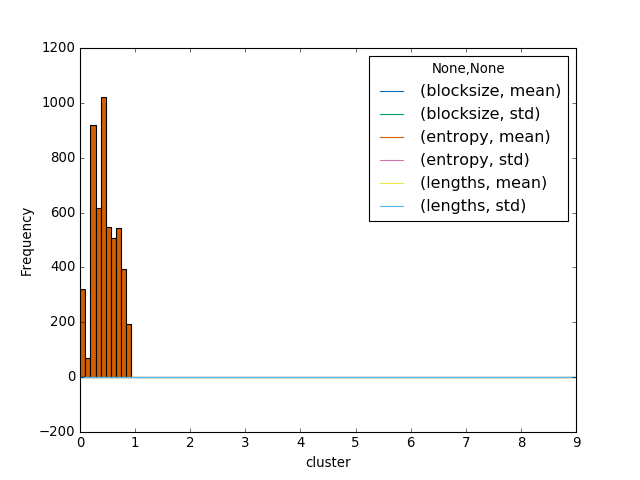

In [165]:
_.plot()

In [144]:
df.groupby('cluster').describe()

assignment    blocksize      entropy       lengths  \
cluster                                                              
0       count   562.000000   562.000000   562.000000  5.620000e+02   
        mean     56.992883   116.583630     0.625219  5.197593e+05   
        std      16.862344   212.935566     0.107214  2.224255e+06   
        min       5.000000     1.000000     0.384334  4.212000e+03   
        25%      43.000000     8.000000     0.544281  2.045000e+04   
        50%      64.000000    16.000000     0.621104  5.726000e+04   
        75%      70.000000    32.000000     0.719790  1.252800e+05   
        max      92.000000   954.000000     0.828525  2.724698e+07   
1       count  1117.000000  1117.000000  1117.000000  1.117000e+03   
        mean     51.761862    60.555058     0.302042  1.437637e+06   
        std      30.543327   138.792979     0.203699  5.498079e+06   
        min      -1.000000     1.000000     0.006950  2.200000e+01   
        25%      37.000000     1.000000     0.037548  7.792000e+03   
        50%      54.000000     8.000000     0.362068  1.813680e+05   
        75%      79.000000    48.000000     0.445125  5.812840e+05   
        max      89.000000   830.000000     0.720498  7.420507e+07   
2       count   371.000000   371.000000   371.000000  3.710000e+02   
        mean     61.401617    41.175202     0.823048  9.242560e+05   
        std      20.231709    99.114970     0.049376  2.986083e+06   
        min       7.000000     1.000000     0.645737  5.719000e+03   
        25%      63.000000    16.000000     0.796496  5.317000e+04   
        50%      70.000000    20.000000     0.825539  3.871000e+05   
        75%      71.000000    24.000000     0.859084  8.282250e+05   
        max      92.000000   535.000000     0.923243  4.395469e+07   
3       count   355.000000   355.000000   355.000000  3.550000e+02   
        mean     64.769014   166.191549     0.362717  1.115287e+06   
        std      13.525980    52.576578     0.032523  3.555804e+06   
        min       3.000000     1.000000     0.212105  1.020000e+04   
        25%      66.000000   170.000000     0.345409  1.350650e+05   
        50%      66.000000   170.000000     0.361182  1.621800e+05   
...                    ...          ...          ...           ...   
6       std      16.565194   240.016737     0.061918  3.574263e+06   
        min       5.000000     1.000000     0.528633  7.094000e+03   
        25%      33.000000    16.000000     0.664138  8.688000e+04   
        50%      54.000000    24.000000     0.694404  1.252800e+05   
        75%      70.000000   522.000000     0.732763  4.091500e+05   
        max      92.000000   648.000000     0.891552  2.914023e+07   
7       count   513.000000   513.000000   513.000000  5.130000e+02   
        mean     61.142300    57.321637     0.487553  1.741846e+06   
        std      18.573892   160.380212     0.110516  3.742595e+06   
        min       5.000000     1.000000     0.215521  1.782000e+03   
        25%      49.000000     2.000000     0.408126  5.428800e+04   
        50%      62.000000     6.000000     0.501992  1.209120e+05   
        75%      82.000000    16.000000     0.563824  1.778150e+06   
        max      92.000000   954.000000     0.814340  2.819898e+07   
8       count    35.000000    35.000000    35.000000  3.500000e+01   
        mean     53.514286    15.742857     0.606933  4.161088e+07   
        std      17.589053    44.525830     0.018356  4.360782e+07   
        min      14.000000     1.000000     0.555393  9.797000e+03   
        25%      49.000000     1.000000     0.611557  5.508608e+06   
        50%      52.000000     1.000000     0.613456  1.874074e+07   
        75%      66.000000     1.000000     0.614236  7.252941e+07   
        max      82.000000   195.000000     0.618370  1.370030e+08   
9       count   548.000000   548.000000   548.000000  5.480000e+02   
        mean     47.454380   106.401460     0.399656  1.876101e+05   
        std      17.939359

<IPython.core.display.Javascript object>


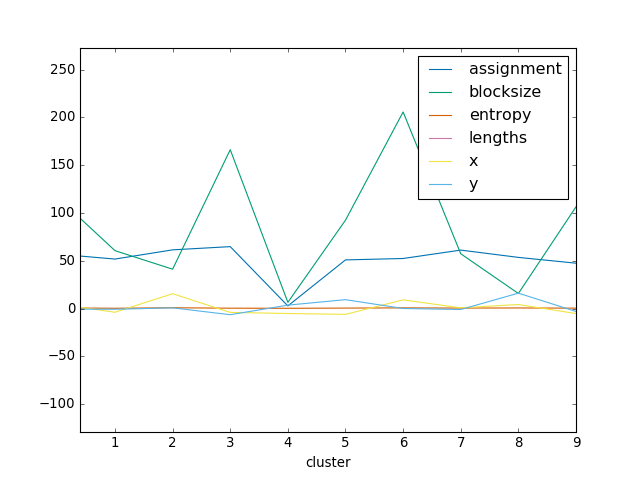

In [146]:
df.groupby('cluster').mean().plot()

In [147]:
df.groupby('cluster').mean()

assignment   blocksize   entropy       lengths          x          y
cluster                                                                      
0         56.992883  116.583630  0.625219  5.197593e+05   4.770585  -0.542081
1         51.761862   60.555058  0.302042  1.437637e+06  -3.886265  -0.770406
2         61.401617   41.175202  0.823048  9.242560e+05  15.514614   0.736854
3         64.769014  166.191549  0.362717  1.115287e+06  -4.060608  -6.461162
4          2.740741    6.484954  0.252797  2.524146e+05  -5.177195   3.554752
5         50.892473   92.462366  0.464104  1.444515e+06  -6.099473   9.284320
6         52.360684  205.656410  0.702603  9.702642e+05   9.058596   0.050048
7         61.142300   57.321637  0.487553  1.741846e+06   0.736513  -1.018192
8         53.514286   15.742857  0.606933  4.161088e+07   4.211491  16.100742
9         47.454380  106.401460  0.399656  1.876101e+05  -5.239837  -3.071403

In [137]:
g = df.groupby(['cluster', 'assignment'])

In [142]:
g.mean()

blocksize   entropy       lengths         x          y
cluster assignment                                                         
0        5          100.000000  0.475131  1.458963e+06  2.783999   2.868811
         11           9.000000  0.601860  1.195602e+07  3.806527   0.340107
         23           9.000000  0.620012  4.878271e+04  4.418494  -1.355473
         24          20.000000  0.644401  4.137778e+04  4.682140   0.066301
         26          20.307692  0.607151  1.677308e+04  5.162357   0.727730
         28           9.000000  0.527312  7.660100e+04  3.902207  -1.330153
         33          25.714286  0.603184  3.892601e+05  5.745656  -0.650485
         43         388.322581  0.548893  1.252297e+05  4.950399   0.172213
         44           3.000000  0.461021  3.929124e+06  4.164781   0.926045
         45         954.000000  0.486596  4.092342e+06  3.178807   0.713966
         54         222.520661  0.517405  1.120288e+05  4.786352   0.308950
         55           4.000000  0.420607  5.280300e+06  3.541722   0.735853
         59         900.000000  0.542928  1.633863e+07  2.836953  -0.601945
         62          64.000000  0.436228  1.018039e+07  3.175226   0.517705
         64          18.000000  0.531327  2.306937e+06  5.597979  -0.284370
         70          15.750000  0.702098  3.112234e+04  4.633419  -1.249278
         71          14.631579  0.720980  2.938342e+04  5.101653  -1.541037
         76          25.000000  0.575393  3.930648e+06  4.251239   0.087389
         78         264.000000  0.560605  1.776679e+07  5.521988   1.314388
         82           2.000000  0.714675  1.309880e+05  6.305347  -1.222398
         85          68.000000  0.539021  7.747470e+05  3.253312   4.230746
         92         357.000000  0.809417  4.816000e+03  4.192372   0.550346
1       -1            1.000000  0.038826  2.466899e+03 -4.745390  -0.314401
         2            8.000000  0.553470  6.833290e+07 -3.053609   1.164871
         5           11.500000  0.192474  3.200000e+01 -4.730896  -0.605667
         7           15.000000  0.346668  1.176000e+03 -4.145380  -0.543397
         8           34.000000  0.645006  9.495966e+06 -3.096799  -0.563883
         14         122.000000  0.373125  6.493886e+04 -4.198282  -1.211170
         32         412.000000  0.266760  2.287215e+07 -1.832864  -0.537370
         34          66.714286  0.527947  9.165943e+06 -3.471001  -0.437927
...                        ...       ...           ...       ...        ...
7        71          13.600000  0.616958  1.247450e+04  1.478113  -1.549152
         74          24.000000  0.438259  1.188110e+06  0.904357   2.768680
         76          17.500000  0.525294  3.823864e+06  2.405560  -0.814115
         78          94.000000  0.329934  5.650011e+04  0.082258  -1.244304
         81         278.000000  0.545566  3.068417e+06  0.649776  -0.643394
         82           9.920000  0.488700  1.355827e+05 -0.103430  -1.468691
         84         102.000000  0.407700  9.435875e+04  0.748290   3.076273
         92         535.000000  0.790660  3.964000e+03  2.304994   0.125074
8        14           1.000000  0.611329  3.445760e+06  4.323920  16.734909
         23           1.000000  0.610847  2.507776e+06  4.309210  16.683387
         24           1.000000  0.611353  2.264064e+06  4.285083  16.718394
         30           1.000000  0.615473  1.370030e+08  4.270151  16.796530
         32           1.000000  0.617630  8.083866e+07  2.857078  12.567830
         43           1.000000  0.609586  2.678272e+07  4.255642  16.643265
         45           1.000000  0.618370  2.049946e+07  3.456802  14.589098
         49           1.000000  0.614143  6.851891e+07  4.278346  16.777580
         52         130.000000  0.555393  1.064200e+04  4.329431  12.735124
         54         130.000000  0.557272  1.059867e+04  4.184487  12.707333
         56           1.000000  0.614846  1.323674e+08  4.287514  16.756703
         65           1.000000  0.613975  1.195203e+08  4.145162  16.

In [139]:
g.apply()

In [138]:
g.apply(len)

cluster  assignment
0         5              5
          11             9
          23            14
          24             9
          26            13
          28             2
          33            28
          43            62
          44             3
          45             6
          54           121
          55             1
          59             1
          62             3
          64             5
          70           192
          71            76
          76             4
          78             1
          82             2
          85             2
          92             3
1        -1            198
          2              1
          5              2
          7              1
          8              3
          14             7
          32             5
          34            49
                      ... 
7         71            20
          74             4
          76             8
          78             9
          81             3
        

# K-Means

In [100]:
dim = 9

In [99]:
km(d2129f, dim)

k: 9, 	 n_samples 19945, 	 n_features 164
_______________________________________________________________________________
init          time  inertia    homo   compl  v-meas     ARI AMI  silhouette


ValueError: labels_true and labels_pred must have same size, got 1797 and 19945

In [20]:
km(digits.data, 10)

k: 10, 	 n_samples 1797, 	 n_features 64
_______________________________________________________________________________
init          time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.31s    69432   0.602   0.650   0.625   0.465   0.598    0.146


In [374]:
%%timeit
KMeans(init='k-means++', n_clusters=dim, n_init=10, n_jobs=-2).fit(d2129f)

1 loop, best of 3: 2.53 s per loop


In [102]:
fit = _

In [109]:
predicts = fit.predict(d2129f)

In [114]:
predicts[:50]

array([2, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6,
       5, 6, 5, 6, 5, 0, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5,
       6, 5, 6, 5], dtype=int32)

In [143]:
d2129c.view('S164')[:5]

array([[ b'\x00s                 131    4                 MAD                     0                                                                                     0000000000'],
       [ b'\x00s  1.  15. 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.7 0.0 283.0 0.93   0.   0. 498.100.00100.00  1.48                   000000'],
       [ b'\x00s  10. 3. 2.26.70 -1.577  69.605506.6  7.40.51.8010.9 3.672100.0  20.9 -10.4 0.0 -10.4 0.0 283.0 0.93   0.   0. 498.100.00100.00  1.48448 66 66 66 66 55 78  000000'],
       [ b'\x00s  2.  15. 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.8 0.0 279.0 0.93   0.   0. 509.100.00100.00  1.44                   000000'],
       [ b'\x00s  10. 3. 2.54.60 -3.336  69.792507.6  7.42. 4.6010.8 3.762100.0  20.9 -10.5 0.0 -10.5 0.0 278.0 0.93   0.   0. 509.100.00100.00  1.44455 67 67 67 67 55 79  000000']], 
      dtype='|S164')

If we take the positions of decimal places as a signature, there are only 6 unique signatures in dr2129: here is a count for each unique tuple of columns.  E.g. 54 records have a "." in columns 7 and 14.

If we use a more specific signature: all columns that have an unusual character or decimal point, we get 9 unique signatures.  Here we look for any character other than a digit, a minus sign and a space.

In [362]:
def dpcols(record):
    "list of columns with decimal points in this byte array"

    chd = [record[col] == b'.' for col in range(record.shape[0])]
    cwd = tuple(i for i,v in enumerate(chd)  if v)
    return cwd

def dpacols(record):
    "list of columns with decimal points or non-number-characters in this byte array"

    chd = [record[col] not in b'-0123456789 ' for col in range(record.shape[0])]
    cwd = tuple(i for i,v in enumerate(chd)  if v)
    return cwd

In [363]:
alldpacols = [dpacols(record) for record in d2129c]

In [364]:
dpacol = collections.Counter(alldpacols)

In [365]:
[(v, str(t)) for t, v in dpacol.items()]

[(883,
  '(1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150)'),
 (8557,
  '(1, 5, 10, 13, 16, 19, 25, 33, 40, 45, 48, 51, 56, 60, 67, 73, 79, 83, 89, 93, 99, 103, 110, 115, 120, 124, 130, 136)'),
 (8503,
  '(1, 6, 9, 12, 15, 21, 29, 36, 41, 44, 47, 52, 56, 63, 69, 75, 79, 85, 89, 95, 99, 106, 111, 116, 120, 126, 132)'),
 (54, '(1, 7, 14)'),
 (324, '(1,)'),
 (249, '(1, 5, 10, 15)'),
 (660,
  '(1, 3, 6, 9, 12, 15, 21, 29, 36, 41, 44, 47, 52, 56, 63, 69, 75, 79, 85, 89, 95, 99, 106, 111, 116, 120, 126, 132)'),
 (660,
  '(1, 5, 7, 10, 13, 16, 19, 25, 33, 40, 45, 48, 51, 56, 60, 67, 73, 79, 83, 89, 93, 99, 103, 110, 115, 120, 124, 130, 136)'),
 (55, '(1, 44, 45, 46)')]

In [369]:
len(dpacol)

9

In [351]:
alldpcols = [dpcols(record) for record in d2129c]

In [336]:
dct = collections.Counter(alldpcols)

In [354]:
len(dct)

6

In [348]:
[(v, str(t)) for t, v in collections.Counter(alldpcols).items()]

[(54, '(7, 14)'),
 (379, '()'),
 (9163,
  '(6, 9, 12, 15, 21, 29, 36, 41, 44, 47, 52, 56, 63, 69, 75, 79, 85, 89, 95, 99, 106, 111, 116, 120, 126, 132)'),
 (9217,
  '(5, 10, 13, 16, 19, 25, 33, 40, 45, 48, 51, 56, 60, 67, 73, 79, 83, 89, 93, 99, 103, 110, 115, 120, 124, 130, 136)'),
 (249, '(5, 10, 15)'),
 (883,
  '(5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150)')]

In [350]:
sum(dct.values())

19945

In [355]:
def summarize(cluster):
    "Show 3 records in given cluster"

    global match
    match = d2129c[predicts == cluster]

    for record in match.view('S164')[:3][:,0]:
        print("%d: %s" % (cluster, str(record[1:110])))

    # col_has_decimalpoints = [any(d[:,col] == b'.') for col in range(d.shape[1])]

    alldpcols = [dpcols(record) for record in match]
    print(len(frozenset(alldpcols)))
    '''
    chd = [match[0,col] == b'.') for col in range(d.shape[1])]
    cwd = [i for i,v in enumerate(col_has_decimalpoints)  if v] [match[0][match[0]
    cwd = match[0][cols_with_decimalpoints].view('S66')
    '''
    for record in match[:3]:
        global lastrec
        lastrec = record
        thiscwd = record[cols_with_decimalpoints].view('S66')
        # chd = ''.join(record[cols_with_decimalpoints])
        # print(chd)
    print()

In [323]:
for cluster in [1, 5, 0, 3, 7, 6, 4, 8, 2]: summarize(cluster)

1: b's  1.  15. 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.7 0.0 283.0 0.93   0'
1: b's  2.  15. 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.8 0.0 279.0 0.93   0'
1: b's  3.  15. 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792100.0  21.1 -15.9 0.0 -15.9 0.0 275.0 0.94   0'
1

5: b's  6.  15. 3. 4.42.80-10.144  70.528512.2  7.46.49.40 9.8 3.672100.0  20.9 -16.2 0.0 -16.2 0.0 266.0 0.97   0'
5: b's  7.  15. 3. 5.10.70-11.898  70.725513.6  7.48. 4.70 9.4 3.552100.0  20.9 -16.3 0.0 -16.3 0.0 264.0 0.98   0'
5: b's  8.  15. 3. 5.38.70-13.651  70.926515.0  7.49.20.80 9.2 3.652100.0  20.6 -16.4 0.0 -16.4 0.0 263.0 1.00   0'
1

0: b's C10. 3. 8.29.70-24.356  72.282525.2  7.57.37.20 7.8 3.252100.0  20.9  21.7 4.6  20.9 4.9 261.0 1.07   0. 43'
0: b's C10. 3.15.56.40-51.842  78.597558.8  8.30.19.70 6.5 3.022100.0  21.1  21.2 4.7  20.4 4.8 282.0 1.27   0. 69'
0: b's C10. 3.23.23.10-76.574 110.286591.4 10.44.31.70 5.8 4.69210

In [307]:
match[0].shape

(164,)

In [376]:
len(match)

466

In [377]:
constant_cols = np.all(match == match[0,:], axis = 0)

In [380]:
match[0][constant_cols].shape

(133,)

In [306]:
match

array([[b'', b's', b' ', ..., b'0', b'0', b'0'],
       [b'', b's', b' ', ..., b' ', b'0', b'0'],
       [b'', b's', b' ', ..., b' ', b'0', b'0'],
       ..., 
       [b'', b's', b' ', ..., b' ', b'0', b'0'],
       [b'', b's', b' ', ..., b' ', b'0', b'0'],
       [b'', b's', b' ', ..., b' ', b'0', b'0']], 
      dtype='|S1')

In [ ]:
[match[0,col] == b'.') for col in range(d.shape[1])]

In [297]:
len(match[1][cols_with_decimalpoints])

66

In [301]:
match[1].view('S164')

array([ b'\x00s  2.  15. 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.8 0.0 279.0 0.93   0.   0. 509.100.00100.00  1.44                   000000'], 
      dtype='|S164')

In [302]:
match[1]

array([b'', b's', b' ', b' ', b'2', b'.', b' ', b' ', b'1', b'5', b'.',
       b' ', b'3', b'.', b' ', b'2', b'.', b'5', b'1', b'.', b'1', b'0',
       b' ', b'-', b'3', b'.', b'1', b'1', b'6', b' ', b' ', b'6', b'9',
       b'.', b'7', b'6', b'8', b'5', b'0', b'7', b'.', b'5', b' ', b' ',
       b'7', b'.', b'4', b'1', b'.', b'5', b'5', b'.', b'5', b'0', b'1',
       b'0', b'.', b'8', b' ', b'3', b'.', b'7', b'6', b'2', b'1', b'0',
       b'0', b'.', b'0', b' ', b' ', b'2', b'0', b'.', b'9', b' ', b'-',
       b'1', b'5', b'.', b'8', b' ', b'0', b'.', b'0', b' ', b'-', b'1',
       b'5', b'.', b'8', b' ', b'0', b'.', b'0', b' ', b'2', b'7', b'9',
       b'.', b'0', b' ', b'0', b'.', b'9', b'3', b' ', b' ', b' ', b'0',
       b'.', b' ', b' ', b' ', b'0', b'.', b' ', b'5', b'0', b'9', b'.',
       b'1', b'0', b'0', b'.', b'0', b'0', b'1', b'0', b'0', b'.', b'0',
       b'0', b' ', b' ', b'1', b'.', b'4', b'4', b' ', b' ', b' ', b' ',
       b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' 

In [303]:
match[1][cols_with_decimalpoints].view('S66')

array([b'.  5.3. 2..10.  .68.57.1.5.50..20.  . .8. .8. .0.3 . . ..00.01.   '], 
      dtype='|S66')

In [288]:
np.core.defchararray.join('', match[1][cols_with_decimalpoints])

TypeError: sequence item 0: expected str instance, int found

In [290]:
np.core.defchararray.join('', charar)

TypeError: sequence item 0: expected str instance, int found

In [215]:
for fit in [1, 5, 0, 3, 7, 6, 4, 8, 2]: summarize(fit)

1: b's  1.  15. 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.7 0.0 283.0 0.93   0'
1: b's  2.  15. 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.8 0.0 279.0 0.93   0'
1: b's  3.  15. 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792100.0  21.1 -15.9 0.0 -15.9 0.0 275.0 0.94   0'

5: b's  6.  15. 3. 4.42.80-10.144  70.528512.2  7.46.49.40 9.8 3.672100.0  20.9 -16.2 0.0 -16.2 0.0 266.0 0.97   0'
5: b's  7.  15. 3. 5.10.70-11.898  70.725513.6  7.48. 4.70 9.4 3.552100.0  20.9 -16.3 0.0 -16.3 0.0 264.0 0.98   0'
5: b's  8.  15. 3. 5.38.70-13.651  70.926515.0  7.49.20.80 9.2 3.652100.0  20.6 -16.4 0.0 -16.4 0.0 263.0 1.00   0'

0: b's C10. 3. 8.29.70-24.356  72.282525.2  7.57.37.20 7.8 3.252100.0  20.9  21.7 4.6  20.9 4.9 261.0 1.07   0. 43'
0: b's C10. 3.15.56.40-51.842  78.597558.8  8.30.19.70 6.5 3.022100.0  21.1  21.2 4.7  20.4 4.8 282.0 1.27   0. 69'
0: b's C10. 3.23.23.10-76.574 110.286591.4 10.44.31.70 5.8 4.692100.0 

In [152]:
d2129c[predicts == 8].view('S164')[:5]

array([[ b'\x00s 167 1 187 4   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0          00'],
       [ b'\x00s   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0          00'],
       [ b'\x00s 122 1 136 4 140 1 143 4 172 1 192 4   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0          00'],
       [ b'\x00s   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0          00'],
       [ b'\x00s 145 1 147 4 156 1 173 4   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0   0 0          00']], 
      dtype='|S164')

In [116]:
d2129e[predicts == 1][:5]

TypeError: only integer arrays with one element can be converted to an index

In [108]:
import collections


In [110]:
collections.Counter(predicts)

Counter({0: 577,
         1: 1363,
         2: 466,
         3: 3830,
         4: 883,
         5: 7854,
         6: 3447,
         7: 1309,
         8: 216})

# Visualize

In [111]:
reduced_data = PCA(n_components=2).fit_transform(d2129f)

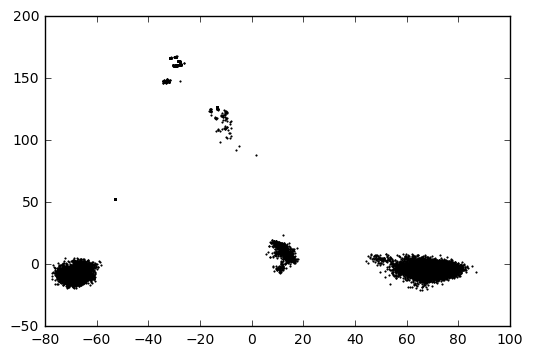

In [217]:
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

In [ ]:
data = d2129f
k = 9

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

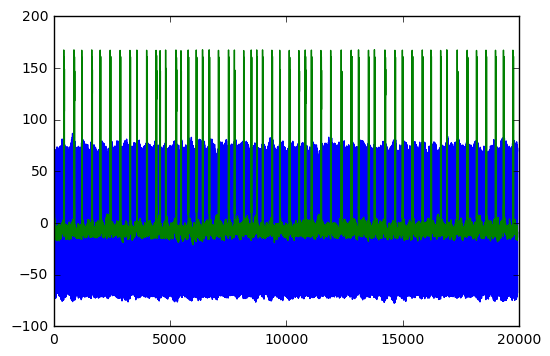

In [112]:
plt.plot(reduced_data)

In [216]:
reduced_data

array([[ -27.81681442,  148.19378032],
       [ -65.40784386,   -2.23664378],
       [  53.01696814,    3.58937344],
       ..., 
       [  72.72337726,   -8.38073736],
       [ -66.90384235,   -9.91014531],
       [  69.97127292,   -9.36810513]])

# MNIST

In [10]:
def bench_k_means(estimator, name, data, sample_size):
    t0 = time.time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time.time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [11]:
def km(data_unscaled, k, labels=None):
    "data_unscaled is a 2D numpy array, one column per feature"
    np.random.seed(42)

    data = scale(data_unscaled)

    n_samples, n_features = data.shape
    labels = labels  or  range(k)

    sample_size = 300

    print("k: %d, \t n_samples %d, \t n_features %d"
          % (k, n_samples, n_features))

    print(79 * '_')
    print('% 9s' % 'init'
          '          time  inertia    homo   compl  v-meas     ARI AMI  silhouette')

    bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data, sample_size=sample_size)

In [11]:
digits['data']

array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  10.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   9.,   0.],
       ..., 
       [  0.,   0.,   1., ...,   6.,   0.,   0.],
       [  0.,   0.,   2., ...,  12.,   0.,   0.],
       [  0.,   0.,  10., ...,  12.,   1.,   0.]])

In [16]:
# k-means on MNIST
np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '          time  inertia    homo   compl  v-meas     ARI AMI  silhouette')

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

n_digits: 10, 	 n_samples 1797, 	 n_features 64
_______________________________________________________________________________
init          time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.28s    69432   0.602   0.650   0.625   0.465   0.598    0.146
   random   0.20s    69694   0.669   0.710   0.689   0.553   0.666    0.147
PCA-based   0.04s    70804   0.671   0.698   0.684   0.561   0.668    0.118
_______________________________________________________________________________


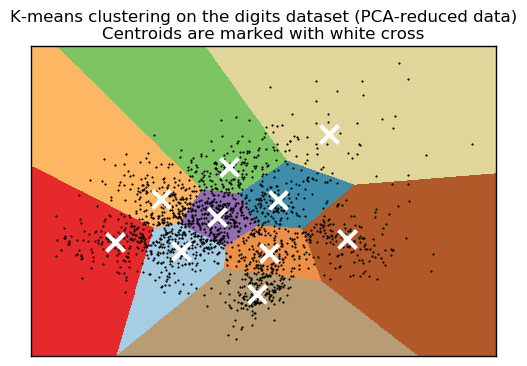

In [7]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Example of Bokeh doing interactive plot of sea surface temperatures queried from the web

In [295]:
import pandas as pd
import yaml

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show

In [296]:
def modify_doc(doc):
    data_url = "http://www.neracoos.org/erddap/tabledap/B01_sbe37_all.csvp?time,temperature&depth=1&temperature_qc=0&time>=2016-02-15&time<=2017-03-22"
    df = pd.read_csv(data_url, parse_dates=True, index_col=0)
    df = df.rename(columns={'temperature (celsius)': 'temperature'})
    df.index.name = 'time'v

    source = ColumnDataSource(data=df)

    plot = figure(x_axis_type='datetime', y_range=(0, 25),
                  y_axis_label='Temperature (Celsius)',
                  title="Sea Surface Temperature at 43.18, -70.43")
    plot.line('time', 'temperature', source=source)

    def callback(attr, old, new):
        if new == 0:
            data = df
        else:
            data = df.rolling('{0}D'.format(new)).mean()
        source.data = ColumnDataSource(data=data).data

    slider = Slider(start=0, end=30, value=0, step=1, title="Smoothing by N Days")
    slider.on_change('value', callback)

    doc.add_root(column(slider, plot))

    doc.theme = Theme(json=yaml.load("""
        attrs:
            Figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 500
                width: 800
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """))

In [297]:
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

handler = FunctionHandler(modify_doc)
app = Application(handler)

In [298]:
show(app)

In [294]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show

p = figure(plot_width=400, plot_height=400,
           tools="tap", title="Click the Dots")

source = ColumnDataSource(data=dict(
    x=[1, 2, 3, 4, 5],
    y=[2, 5, 8, 2, 7],
    color=["navy", "orange", "olive", "firebrick", "gold"]
    ))

p.circle('x', 'y', color='color', size=20, source=source)

url = "http://www.colors.commutercreative.com/@color/"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)